In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_9125/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import os
import shutil

import numpy as np
import time
from pyDOE import lhs
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

In [3]:
import argparse
class Options_HeatHD:
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--cuda', default=True, help='if you use cuda')
        
        parser.add_argument('--bot_top', type=tuple, default=(-1, 1), help='a tuple of the form (bot, top)')
        parser.add_argument('--T', type=float, default=1., help='a float T of time domain [0, T]')
        parser.add_argument('--dim', default=50, help='dimension')
        parser.add_argument('--N_r', default=2400, help='num of interior points')
        parser.add_argument('--N_b', default=1200, help='num of boundary points')
        parser.add_argument('--N_0', default=1200, help='num of initial points')
        
        parser.add_argument('--backbone_layers', type=list, default=([60]*5), help='list of nn layers of backbone')
        parser.add_argument('--subnet_layers', type=list, default=([200]*1), help='list of nn layers of subnet')
        
        parser.add_argument('--backbone_lr', type=float, default=5e-3, help='initial learning rate of backbone')
        parser.add_argument('--subnet_lr', type=float, default=5e-3, help='initial learning rate of subnet')
        
        parser.add_argument('--backbone_gamma', type=float, default=0.85, help='gamma in lr_scheduler for backbone optimizer')
        parser.add_argument('--subnet_gamma', type=float, default=0.95, help='gamma in lr_scheduler for subnet optimizer')
        parser.add_argument('--step_size', type=int, default=12000, help='step_size of lr_scheduler for Adam optimizer')
        
        parser.add_argument('--iters_stage1', type=int, default=0, help='iters for stage 1 used Adam')
        parser.add_argument('--iters_stage2', type=int, default=0, help='iters for stage 2 used Adam')
        parser.add_argument('--iters_stage3', type=int, default=240000, help='iters for stage 3 used Adam')
        parser.add_argument('--iters_stage4', type=int, default=0, help='iters for stage 4 used Adam')
        
        parser.add_argument('--lam_res', type=float, default=1, help='weight of loss_res')
        parser.add_argument('--lam_bcs', type=float, default=1, help='weight of loss_bcs')
        parser.add_argument('--lam_ics', type=float, default=1, help='weight of loss_ics')
        parser.add_argument('--K1', type=int, default=500, help='for stage3, optimize the backbone K1 times every (K1+K2) iters')
        parser.add_argument('--K2', type=int, default=100, help='for stage3, optimize the transformer K2 times every (K1+K2) iters')
        parser.add_argument('--k_scale', type=float, default=0.1, help='the scale of transformer limited residue')
        
        self.parser = parser

    def parse_default(self):
        args = self.parser.parse_args(args=[])
        args.device = torch.device('cuda' if args.cuda else 'cpu')
        
        # 增加网络输入输出层
        args.backbone_layers = [args.dim + 1] + args.backbone_layers + [1]
        args.subnet_layers = [args.dim + 1] + args.subnet_layers + [args.dim + 1]
        return args
    

args = Options_HeatHD().parse_default()
print(args.cuda)

True


In [4]:
def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth')
        shutil.copyfile(last_model, best_model)

def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [5]:
seed_torch(42)

## 网络模型 (Modified ResNet / ResNet / Modified MLP / MLP)

In [6]:
class ModifiedResNet(nn.Module):
    def __init__(self, mlp_layers):
        super(ModifiedResNet, self).__init__()
        
        self.encoder_u = nn.Sequential()
        self.encoder_u.add_module('fc_u', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_u.add_module('act_u', nn.Tanh())
        
        self.encoder_v = nn.Sequential()
        self.encoder_v.add_module('fc_v', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_v.add_module('act_v', nn.Tanh())
        
        self.model = nn.Sequential()
        
        first_layer = nn.Sequential()
        first_layer.add_module(f'fc0', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        first_layer.add_module(f'act0', nn.Tanh())
        self.model.add_module(f'first', first_layer)
        
        for i in range(1, len(mlp_layers)-2):
            block = nn.Sequential()
            block.add_module(f'fc{i}_0', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_0', nn.Tanh())
            block.add_module(f'fc{i}_1', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_1', nn.Tanh())
            self.model.add_module(f'block{i}', block)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'last', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        u = self.encoder_u(X)
        v = self.encoder_v(X)
        
        X = self.model[0](X)
        for i_block in range(1, len(self.model) - 1):
            X_ = self.model[i_block](X)
            X = X + X_
            X = X / 2.
            X = (1 - X) * u + X * v
        return self.model[-1](X)

In [7]:
class ResNet(nn.Module):
    def __init__(self, mlp_layers):
        super(ResNet, self).__init__()
        
        self.model = nn.Sequential()
        
        first_layer = nn.Sequential()
        first_layer.add_module(f'fc0', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        first_layer.add_module(f'act0', nn.Tanh())
        self.model.add_module(f'first', first_layer)
        
        for i in range(1, len(mlp_layers)-2):
            block = nn.Sequential()
            block.add_module(f'fc{i}_0', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_0', nn.Tanh())
            block.add_module(f'fc{i}_1', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_1', nn.Tanh())
            self.model.add_module(f'block{i}', block)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'last', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        X = self.model[0](X)
        for i_block in range(1, len(self.model) - 1):
            X_ = self.model[i_block](X)
            X = X_ + X
        return self.model[-1](X)

In [8]:
class ModifiedMLP(nn.Module):
    def __init__(self, mlp_layers):
        super(ModifiedMLP, self).__init__()
        
        self.encoder_u = nn.Sequential()
        self.encoder_u.add_module('fc_u', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_u.add_module('act_u', nn.Tanh())
        
        self.encoder_v = nn.Sequential()
        self.encoder_v.add_module('fc_v', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_v.add_module('act_v', nn.Tanh())
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        u = self.encoder_u(X)
        v = self.encoder_v(X)
        
        for i in range(len(self.model) - 1):
            X = self.model[i](X)
            X = X / 2.
            X = (1 - X) * u + X * v
        return self.model[-1](X)

In [9]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)


In [10]:
backbone = ResNet(args.backbone_layers)
backbone = backbone.to(args.device)
args.backbone = backbone
print(args.backbone)

ResNet(
  (model): Sequential(
    (first): Sequential(
      (fc0): Linear(in_features=51, out_features=60, bias=True)
      (act0): Tanh()
    )
    (block1): Sequential(
      (fc1_0): Linear(in_features=60, out_features=60, bias=True)
      (act1_0): Tanh()
      (fc1_1): Linear(in_features=60, out_features=60, bias=True)
      (act1_1): Tanh()
    )
    (block2): Sequential(
      (fc2_0): Linear(in_features=60, out_features=60, bias=True)
      (act2_0): Tanh()
      (fc2_1): Linear(in_features=60, out_features=60, bias=True)
      (act2_1): Tanh()
    )
    (block3): Sequential(
      (fc3_0): Linear(in_features=60, out_features=60, bias=True)
      (act3_0): Tanh()
      (fc3_1): Linear(in_features=60, out_features=60, bias=True)
      (act3_1): Tanh()
    )
    (block4): Sequential(
      (fc4_0): Linear(in_features=60, out_features=60, bias=True)
      (act4_0): Tanh()
      (fc4_1): Linear(in_features=60, out_features=60, bias=True)
      (act4_1): Tanh()
    )
    (last): S

## 对抗TransformerNet

In [11]:
class TransformerNet(nn.Module):
    def __init__(self, model, bot_top, T, dim):
        super(TransformerNet, self).__init__()
        self.model = model
        bot, top = bot_top
        
        x_len = torch.ones(dim) * (top - bot)
        t_len = torch.ones(1) * T
        self.len = torch.cat([x_len, t_len], dim=0)
        
        x_mid = torch.ones(dim) * (bot + top) / 2
        t_mid = torch.ones(1) * T / 2
        self.mid = torch.cat([x_mid, t_mid], dim=0)
        
    def input_transform(self, X):
        """输入变换 压缩到[-1,1]再传入arcsin"""
        return torch.arcsin((X - self.mid) / self.len * 2.) / torch.pi
    
    def output_transform(self, X):
        # to PDE's domain 非线性放缩
        return torch.sin(torch.pi * X) / 2. * self.len + self.mid
    
    def forward(self, X, residual_limit):
        X = self.input_transform(X)
        X_ = self.model(X)
        
        X_ = torch.tanh(X_) * residual_limit  # 限制变换残差的界
        
        X = self.output_transform(X + X_)
        return X
    

model = MLP(args.subnet_layers)
transformer = TransformerNet(model, args.bot_top, args.T, args.dim)
transformer = transformer.to(args.device)
args.transformer = transformer
args.transformer.len = args.transformer.len.to(args.device)
args.transformer.mid = args.transformer.mid.to(args.device)
print(args.transformer)

TransformerNet(
  (model): MLP(
    (model): Sequential(
      (layer0): Sequential(
        (fc0): Linear(in_features=51, out_features=200, bias=True)
        (act0): Tanh()
      )
      (layer1): Sequential(
        (fc1): Linear(in_features=200, out_features=51, bias=False)
      )
    )
  )
)


## 数据集生成

In [12]:
class Dataset_HeatHD:
    def __init__(self, bot_top, T, dim, device, N_max=100000):
        self.bot, self.top = bot_top
        self.T = T
        self.dim = dim
        self.device = device
        self.N_max = N_max
    
    def train_data(self, N_r, N_b, N_0):
        """训练点采样"""
        X_res = self.interior(N_r).to(self.device)
        X_bcs = self.boundary(N_b).to(self.device)
        X_ics = self.initial(N_0).to(self.device)
        f_res = self.func_res(X_res).to(self.device)
        u_bcs = self.func_bcs(X_bcs).to(self.device)
        u_ics = self.func_ics(X_ics).to(self.device)
        
        return X_res, X_bcs, X_ics, f_res, u_bcs, u_ics
    
    def interior(self, N_r):
        """内部点采样"""
        X_res = torch.Tensor(self.N_max, self.dim).uniform_(self.bot, self.top)
        idx = torch.randperm(self.N_max)
        idx = idx[:N_r]
        
        T = torch.Tensor(self.N_max, 1).uniform_(0, self.T)
        X_res = torch.cat([X_res[idx], T[idx]], dim=1)  # 拼接X和T
        return X_res
    
    def boundary(self, N_b):
        """边界点采样"""
        X_bcs = torch.Tensor(self.N_max, self.dim).uniform_(self.bot, self.top)
        bots = self.bot * torch.ones(1, 1)
        tops = self.top * torch.ones(1, 1)
        
        n = int(self.N_max / self.dim / 2)
        num = [n * i for i in range(2 * self.dim)]
        num[0] = 0
        num.append(self.N_max)
        
        for i in range(self.dim):  # 逐个维度设为下界bot 以及上界top 得到边界点
            X_bcs[num[2 * i]:num[2 * i + 1], i] = bots.repeat(num[2 * i + 1] - num[2 * i], 1).squeeze()
            X_bcs[num[2 * i + 1]:num[2 * i + 2], i] = tops.repeat(num[2 * i + 2] - num[2 * i + 1], 1).squeeze()

        idx = torch.randperm(self.N_max)
        idx = idx[:N_b]
        
        T = torch.Tensor(self.N_max, 1).uniform_(0, self.T)
        X_bcs = torch.cat([X_bcs[idx], T[idx]], dim=1)  # 拼接X和T
        return X_bcs
    
    def initial(self, N_0):
        """初始点采样"""
        X_ics = torch.Tensor(self.N_max, self.dim).uniform_(self.bot, self.top)
        idx = torch.randperm(self.N_max)
        idx = idx[:N_0]
        
        T = torch.Tensor(self.N_max, 1).fill_(0.)
        X_ics = torch.cat([X_ics[idx], T[idx]], dim=1)
        return X_ics
    
    def func_res(self, X_res):
        """控制方程右端项"""
        f = X_res[:, :self.dim].mean(axis=1, keepdims=True)
        f = (1/self.dim - 1) * torch.cos(f) * torch.exp(- X_res[:, [-1]])
        return f
    
    def func_bcs(self, X_bcs):
        """边界条件右端项"""
        u_bcs = X_bcs[:, :self.dim].mean(axis=1, keepdims=True)
        u_bcs = torch.cos(u_bcs) * torch.exp(- X_bcs[:, [-1]])
        return u_bcs
    
    def func_ics(self, X_ics):
        """初始条件右端项"""
        u_ics = X_ics[:, :self.dim].mean(axis=1, keepdims=True)
        u_ics = torch.cos(u_ics)
        return u_ics


dataset = Dataset_HeatHD(args.bot_top, args.T, args.dim, args.device)
args.dataset = dataset
X_res, X_bcs, X_ics, f_res, u_bcs, u_ics = dataset.train_data(args.N_r, args.N_b, args.N_0)
print(X_res.shape, X_bcs.shape, X_ics.shape, f_res.shape, u_bcs.shape, u_ics.shape)

torch.Size([2400, 51]) torch.Size([1200, 51]) torch.Size([1200, 51]) torch.Size([2400, 1]) torch.Size([1200, 1]) torch.Size([1200, 1])


## 训练

In [13]:
class Trainer_HeatHD:
    def __init__(self, args):
        self.args = args
        self.dim = args.dim
        self.device = args.device
        
        self.N_r = args.N_r
        self.N_b = args.N_b
        self.N_0 = args.N_0
        self.dataset = args.dataset
        
        self.lam_res = args.lam_res
        self.lam_bcs = args.lam_bcs
        self.lam_ics = args.lam_ics
        self.backbone = args.backbone
        
        self.model_name = self.backbone.__class__.__name__
        self.model_path = self.get_model_path()
        
        self.iters_stage1 = args.iters_stage1
        self.iters_stage2 = args.iters_stage2
        self.iters_stage3 = args.iters_stage3
        self.iters_stage4 = args.iters_stage4
        
        self.K1 = args.K1
        self.K2 = args.K2

        # eps = np.finfo(np.float32).eps
        self.optimizer_Adam = optim.Adam(self.backbone.parameters(), lr=args.backbone_lr, betas=(0.9, 0.999))
        
        self.step_size = args.step_size#int( self.iters_stage4 / (np.log(1e-3) / np.log(self.gamma)) )
        self.scheduler = ExponentialLR(self.optimizer_Adam, gamma=args.backbone_gamma, verbose=True)
        
        # subnet (transformer net)
        self.transformer = args.transformer
        self.optimizer_Adam_transformer = optim.Adam(self.transformer.parameters(), lr=args.subnet_lr)    
        self.scheduler_transformer = ExponentialLR(self.optimizer_Adam_transformer, gamma=args.subnet_gamma, verbose=True)
        
        # data
        self.X_res, self.X_bcs, self.X_ics, self.f_res, self.u_bcs, self.u_ics = self.dataset.train_data(self.N_r, self.N_b, self.N_0)
        
        # Logger
        self.logger = {
            f"stage{i + 1}": {
                "loss": [],
                "loss_res": [],
                "loss_bcs": [],
                "loss_ics": [],
                "iter": [],
            }
            for i in range(4)
        }
        self.logger_valid = {
            f"stage{i + 1}": {
                "loss": [],
                "loss_res": [],
                "loss_bcs": [],
                "loss_ics": [],
                "iter": [],
                "error": [],  # relative l2 error
                
                "loss_transformer": [],
                "loss_res_transformer": [],
                "loss_bcs_transformer": [],
                "loss_ics_transformer": [],
                "error_transformer": [],  # 同一批点 经过transformer变换的rl2
                
                "distant": {"mean":[], "var":[], "min":[], "max":[]},
            }
            for i in range(4)
        }
        
        self.backbone_requires_grad = None  # 用以判断是否要更新该网络
        self.transformer_requires_grad = None
        
        self.k = None
        self.k_scale = args.k_scale
        
    def get_model_path(self):
        """生成保存模型的路径"""
        if not os.path.exists('models'):
            os.mkdir('models')
        
        path = os.path.join('models', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
        
        return path
        
    def update_train_data(self, update_k=False):
        """更新采样点"""
        self.X_res, self.X_bcs, self.X_ics, self.f_res, self.u_bcs, self.u_ics = self.dataset.train_data(self.N_r, self.N_b, self.N_0)

        if update_k:
            self.k = self.update_k(self.X_res, self.f_res)
        
    def update_k(self, X_res, f_res):
        """将X_res输入net_r 确定这批X_res的限制残差的系数k"""
        self.backbone.train(False)
        
        f_res_pred = self.net_r(X_res)
        k = (f_res_pred - f_res) ** 2
#         k_sort = torch.sort(k.flatten(), dim=0).values
#         k_min2 = k_sort[10]  # 不取最小值 取近似近似的
#         k_max2 = k_sort[-10]
#         k = k / (k_max2 - k_min2)
        k = k / (k.max() - k.min())
        self.backbone.train()
        return k.detach_() * self.k_scale
    
    def compute_distant_mean_var(self, X1, X2):
        d = ((X1 - X2) ** 2).sum(axis=1) ** 0.5
        return d.mean().item(), d.var().item(), d.min().item(), d.max().item()
            
    def set_backbone_requires_grad(self, bl):
        """设置backbone是否记录梯度"""
        self.backbone_requires_grad = bl
        for param in self.backbone.parameters():
            param.requires_grad = bl

    def set_transformer_requires_grad(self, bl):
        """设置transformer是否记录梯度"""
        self.transformer_requires_grad = bl
        for param in self.transformer.parameters():
            param.requires_grad = bl

    def net_u(self, X):
        return self.backbone(X)

    def net_r(self, xt):
        xt.requires_grad_(True)
        
        u = self.net_u(xt)
        grad_u = grad(u, xt)[0]
        
        u_t = grad_u[:, [-1]]
        u_xx = torch.zeros(u.shape).to(self.device)
        for i in range(self.dim):
            u_xx += grad(grad_u[:, [i]], xt)[0][:, [i]]
        return u_t - u_xx
    
    def net_transformer(self, X, k):
        X.requires_grad_(False)
        return self.transformer(X, k)
    
    def compute_loss(self, use_transformer=False):
        """计算loss 可选择是否使用transformer"""
        if use_transformer:
            if self.transformer_requires_grad and not self.backbone_requires_grad:
                # 只更新transformer 训练点只考虑变换后的X_res_ 用loss_res
                
                self.X_res_ = self.X_res.clone().detach()
                self.X_res_ = self.net_transformer(self.X_res_, self.k)
                # clone会新开辟一片内存 detach会从计算图剥离
                # 用X_res_.clone().detach()计算f_res
                # 可以避免X_res计算图混乱
                # 从而保证transformer的网络正常地梯度传播
                self.f_res_ = self.dataset.func_res(self.X_res_.clone().detach())  # 细节

                f_res_pred_ = self.net_r(self.X_res_)
                
                self.loss_res = torch.mean((f_res_pred_ - self.f_res_) ** 2)
                self.loss = self.lam_res * self.loss_res
                
            elif self.backbone_requires_grad and not self.transformer_requires_grad:
                # 只更新backbone 训练点考虑变换前后的X_res X_res_ X_bcs X_ics 用loss_res和loss_bcs loss_ics
                
                self.X_res_ = self.X_res.clone().detach()
                self.X_res_ = self.net_transformer(self.X_res_, self.k)
                self.f_res_ = self.dataset.func_res(self.X_res_.clone().detach())  # 细节
                
                f_res_pred_ = self.net_r(self.X_res_)
                
                self.loss_res = torch.mean((f_res_pred_ - self.f_res_) ** 2)

                u_bcs_pred = self.net_u(self.X_bcs)
                self.loss_bcs = torch.mean((u_bcs_pred - self.u_bcs) ** 2)
                
                u_ics_pred = self.net_u(self.X_ics)
                self.loss_ics = torch.mean((u_ics_pred - self.u_ics) ** 2)

                self.loss = self.lam_res * self.loss_res + self.lam_bcs * self.loss_bcs + self.lam_ics * self.loss_ics
            else:
                raise "error at compute_loss"
        else:
            f_res_pred = self.net_r(self.X_res)
            self.loss_res = torch.mean((f_res_pred - self.f_res) ** 2)

            u_bcs_pred = self.net_u(self.X_bcs)
            self.loss_bcs = torch.mean((u_bcs_pred - self.u_bcs) ** 2)
            
            u_ics_pred = self.net_u(self.X_ics)
            self.loss_ics = torch.mean((u_ics_pred - self.u_ics) ** 2)

            self.loss = self.lam_res * self.loss_res + self.lam_bcs * self.loss_bcs + self.lam_ics * self.loss_ics

    def log_loss(self):
        """记录当前loss至logger字典"""
        self.logger[f"stage{self.current_stage}"]["loss"].append(self.loss.item())
        self.logger[f"stage{self.current_stage}"]["loss_res"].append(self.loss_res.item())
        self.logger[f"stage{self.current_stage}"]["loss_bcs"].append(self.loss_bcs.item())
        self.logger[f"stage{self.current_stage}"]["loss_ics"].append(self.loss_ics.item())
        self.logger[f"stage{self.current_stage}"]["iter"].append(self.iter + 1)

    def log_info(self):
        """保存并打印训练信息"""
        info = f'Stage {self.current_stage} Iter {self.iter+1:5d} Time:{time.time()-self.start_time:.1e} # ' + \
               f'Loss:{self.loss.item():.2e}, Loss_r:{self.loss_res.item():.2e}, Loss_b:{self.loss_bcs.item():.2e}, Loss_0:{self.loss_ics.item():.2e} # ' + \
               f'Valid:{self.valid_loss_value:.2e}, RL2:{self.error_u:.2e}'
        with open("train_info.txt", 'a') as f:
            f.write(info + '\n')
        print(info)
        
    def compute_rl2(self, X_res):
        """计算relative l2 error"""
        u_star = X_res[:, :self.dim].mean(axis=1, keepdims=True)  # 计算解析解
        u_star = torch.cos(u_star) * torch.exp(- X_res[:, [-1]])
        u_star = u_star.detach().cpu().numpy()
        
        u_pred = self.net_u(X_res)  # 计算预测解
        u_pred = u_pred.detach().cpu().numpy()
        
        error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)  # rl2 error
        return error_u

    def valid(self):
        """验证并保存最优模型"""
        # 计算loss
        X_res, X_bcs, X_ics, f_res, u_bcs, u_ics = self.dataset.train_data(1000, 1000, 1000)
        k = self.update_k(X_res, f_res)
        
        self.backbone.eval()
        self.transformer.eval()
        # 不经过transformer的loss
        f_res_pred = self.net_r(X_res)
        u_bcs_pred = self.net_u(X_bcs)
        u_ics_pred = self.net_u(X_ics)
        loss_res = torch.mean((f_res_pred - f_res) ** 2)
        loss_bcs = torch.mean((u_bcs_pred - u_bcs) ** 2)
        loss_ics = torch.mean((u_ics_pred - u_ics) ** 2)
        loss = self.lam_res * loss_res + self.lam_bcs * loss_bcs + self.lam_ics * loss_ics
        
        # 经过transformer后的内部点的loss
        X_res_ = self.net_transformer(X_res, k)
        f_res_ = self.dataset.func_res(X_res_.clone().detach())  # 计算相应X_res_的新的f_res_
        f_res_pred_transformer = self.net_r(X_res_)
        u_bcs_pred_transformer = self.net_u(X_bcs)  # 边界点也计算 对比经过和不经过transformer的两次loss 确保两次loss是基于同一批训练点
        u_ics_pred_transformer = self.net_u(X_ics)
        loss_res_transformer = torch.mean((f_res_pred_transformer - f_res_) ** 2)
        loss_bcs_transformer = torch.mean((u_bcs_pred_transformer - u_bcs) ** 2)
        loss_ics_transformer = torch.mean((u_ics_pred_transformer - u_ics) ** 2)
        loss_transformer = self.lam_res * loss_res_transformer + self.lam_bcs * loss_bcs_transformer + self.lam_ics * loss_ics_transformer
        
        # 计算relative l2 error
        self.error_u = self.compute_rl2(X_res)
        self.error_u_transformer = self.compute_rl2(X_res_)  # 经过transformer变换的内部点 看看其rl2是否会更大 即更难学
        
        # 计算经过transformer后的变化距离信息
        d_mean, d_var, d_min, d_max = self.compute_distant_mean_var(X_res, X_res_)
        
        self.backbone.train()
        self.transformer.train()
        
        # 记录valid的loss和rl2 error信息
        self.logger_valid[f"stage{self.current_stage}"]["loss"].append(loss.item())
        self.logger_valid[f"stage{self.current_stage}"]["loss_res"].append(loss_res.item())
        self.logger_valid[f"stage{self.current_stage}"]["loss_bcs"].append(loss_bcs.item())
        self.logger_valid[f"stage{self.current_stage}"]["loss_ics"].append(loss_ics.item())
        self.logger_valid[f"stage{self.current_stage}"]["iter"].append(self.iter + 1)
        self.logger_valid[f"stage{self.current_stage}"]["error"].append(self.error_u)
        
        self.logger_valid[f"stage{self.current_stage}"]["loss_transformer"].append(loss_transformer.item())
        self.logger_valid[f"stage{self.current_stage}"]["loss_res_transformer"].append(loss_res_transformer.item())
        self.logger_valid[f"stage{self.current_stage}"]["loss_bcs_transformer"].append(loss_bcs_transformer.item())
        self.logger_valid[f"stage{self.current_stage}"]["loss_ics_transformer"].append(loss_ics_transformer.item())
        self.logger_valid[f"stage{self.current_stage}"]["error_transformer"].append(self.error_u_transformer)
        
        self.logger_valid[f"stage{self.current_stage}"]["distant"]["mean"].append(d_mean)
        self.logger_valid[f"stage{self.current_stage}"]["distant"]["var"].append(d_var)
        self.logger_valid[f"stage{self.current_stage}"]["distant"]["min"].append(d_min)
        self.logger_valid[f"stage{self.current_stage}"]["distant"]["max"].append(d_max)
        
        # 验证模型loss是否最优并选择保存
        self.valid_loss_value = loss.item()
        is_best = self.valid_loss_value < self.best_loss
        if is_best:
            self.best_loss = self.valid_loss_value
        state = {
            'stage': self.current_stage,
            'iter': self.iter,
            'state_dict': self.backbone.state_dict(),
            'state_dict_transformer': self.transformer.state_dict(),
            'best_loss': self.best_loss
        }
        save_model(state, is_best, save_dir=self.model_path)
    
    def train(self):
        """DAR 4个Stage 训练"""
        self.start_time = time.time()
        self.best_loss = 1.e10
        
        # stage1 只训练backbone
        self.iter = 0
        self.current_stage = 1  # 设置当前stage
        self.set_backbone_requires_grad(True)  # 记录backbone的梯度
        self.set_transformer_requires_grad(False)  # 不记录transformer的梯度
        for _ in range(self.iters_stage1):
            self.optimizer_Adam.zero_grad()
            self.compute_loss(use_transformer=False)
            self.loss.backward()
            self.optimizer_Adam.step()
            self.log_loss()        
            
            if (self.iter + 1) % 100 == 0:
                self.valid()
                self.log_info()
                self.update_train_data()
            if (self.iter + 1) % self.step_size == 0:
                self.scheduler.step()
            self.iter += 1
            
            
        self.k = self.update_k(self.X_res, self.f_res)
            
                
        # stage2 只训练transformer
        self.iter = 0
        self.current_stage = 2
        self.set_backbone_requires_grad(False)
        self.set_transformer_requires_grad(True)
        for _ in range(self.iters_stage2):       
            self.optimizer_Adam_transformer.zero_grad()
            self.compute_loss(use_transformer=True)
            self.loss.backward()

            for param in self.transformer.parameters():
                if param.requires_grad == True:
                    param.grad *= -1
            self.optimizer_Adam_transformer.step()

            self.log_loss()
            
            if (self.iter + 1) % 10 == 0:
                self.valid()
                self.log_info()
                self.update_train_data(update_k=True)
            if (self.iter + 1) % self.step_size == 0:
                self.scheduler_transformer.step()
            self.iter += 1

        # stage3 同时训练backbone和transformer
        self.iter = 0
        self.current_stage = 3
        self.set_backbone_requires_grad(True)
        self.set_transformer_requires_grad(True)
        for _ in range(self.iters_stage3):
            self.optimizer_Adam.zero_grad()
            self.optimizer_Adam_transformer.zero_grad()
            
            # 优化K1次backbone 再优化K2次transformer 如此往复
            if (self.iter % (self.K1 + self.K2)) < self.K1:
                # 使用transformer优化backbone
                self.set_backbone_requires_grad(True)
                self.set_transformer_requires_grad(False)
                self.compute_loss(use_transformer=True)
                self.loss.backward()
                self.optimizer_Adam.step()
            else:
                # 优化transformer
                self.set_backbone_requires_grad(False)
                self.set_transformer_requires_grad(True)
                self.compute_loss(use_transformer=True)
                self.loss.backward()

                for param in self.transformer.parameters():
                    if param.requires_grad == True:
                        param.grad *= -1
                self.optimizer_Adam_transformer.step()
            
            self.log_loss()

            if (self.iter + 1) % 100 == 0:
                self.valid()
                self.log_info()
                self.update_train_data(update_k=True)
                
            if (self.iter + 1) % self.step_size == 0:
                self.scheduler.step()
                self.scheduler_transformer.step()
            self.iter += 1
            
        # stage4 只训练backbone
        self.iter = 0
        self.current_stage = 4
        self.set_backbone_requires_grad(True)
        self.set_transformer_requires_grad(False)
        for _ in range(self.iters_stage4):
            self.optimizer_Adam.zero_grad()
            self.compute_loss(use_transformer=False)
            self.loss.backward()
            self.optimizer_Adam.step()
            self.log_loss()

            if (self.iter + 1) % 100 == 0:
                self.valid()
                self.log_info()
                self.update_train_data()

            if (self.iter + 1) % self.step_size == 0:
                self.scheduler.step()
            self.iter += 1
            
            
trainer = Trainer_HeatHD(args)

Adjusting learning rate of group 0 to 5.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-03.


In [14]:
trainer.train()

Stage 3 Iter   100 Time:2.3e+01 # Loss:1.51e-03, Loss_r:1.09e-03, Loss_b:2.27e-04, Loss_0:1.86e-04 # Valid:1.68e-03, RL2:2.37e-02
Stage 3 Iter   200 Time:4.4e+01 # Loss:2.41e-02, Loss_r:1.13e-02, Loss_b:3.88e-03, Loss_0:8.94e-03 # Valid:3.14e-03, RL2:2.45e-02
Stage 3 Iter   300 Time:6.7e+01 # Loss:5.68e-04, Loss_r:4.46e-04, Loss_b:5.61e-05, Loss_0:6.65e-05 # Valid:5.53e-04, RL2:1.14e-02
Stage 3 Iter   400 Time:8.9e+01 # Loss:3.71e-04, Loss_r:2.87e-04, Loss_b:3.56e-05, Loss_0:4.83e-05 # Valid:4.19e-04, RL2:9.64e-03
Stage 3 Iter   500 Time:1.1e+02 # Loss:2.72e-04, Loss_r:2.13e-04, Loss_b:2.52e-05, Loss_0:3.43e-05 # Valid:3.29e-04, RL2:8.21e-03
Stage 3 Iter   600 Time:1.3e+02 # Loss:2.70e-04, Loss_r:2.70e-04, Loss_b:2.52e-05, Loss_0:3.43e-05 # Valid:3.18e-04, RL2:8.40e-03
Stage 3 Iter   700 Time:1.5e+02 # Loss:2.67e-04, Loss_r:2.09e-04, Loss_b:2.55e-05, Loss_0:3.24e-05 # Valid:3.81e-04, RL2:1.05e-02
Stage 3 Iter   800 Time:1.8e+02 # Loss:1.99e-04, Loss_r:1.51e-04, Loss_b:1.89e-05, Loss_0:

Stage 3 Iter  6500 Time:1.4e+03 # Loss:3.22e+07, Loss_r:3.22e+07, Loss_b:2.39e+00, Loss_0:2.32e+00 # Valid:6.76e+08, RL2:2.19e+00
Stage 3 Iter  6600 Time:1.5e+03 # Loss:2.81e+09, Loss_r:2.81e+09, Loss_b:2.39e+00, Loss_0:2.32e+00 # Valid:9.70e+09, RL2:2.40e+00
Stage 3 Iter  6700 Time:1.5e+03 # Loss:1.39e+08, Loss_r:1.39e+08, Loss_b:3.48e+00, Loss_0:3.57e+00 # Valid:6.00e+07, RL2:2.86e+00
Stage 3 Iter  6800 Time:1.5e+03 # Loss:1.71e+07, Loss_r:1.71e+07, Loss_b:3.57e+00, Loss_0:3.98e+00 # Valid:4.69e+07, RL2:2.87e+00
Stage 3 Iter  6900 Time:1.5e+03 # Loss:1.44e+07, Loss_r:1.44e+07, Loss_b:3.55e+00, Loss_0:4.19e+00 # Valid:1.69e+08, RL2:2.83e+00
Stage 3 Iter  7000 Time:1.5e+03 # Loss:2.26e+07, Loss_r:2.26e+07, Loss_b:3.71e+00, Loss_0:3.96e+00 # Valid:2.75e+08, RL2:2.82e+00
Stage 3 Iter  7100 Time:1.6e+03 # Loss:1.20e+07, Loss_r:1.20e+07, Loss_b:3.63e+00, Loss_0:3.79e+00 # Valid:4.34e+07, RL2:2.78e+00
Stage 3 Iter  7200 Time:1.6e+03 # Loss:1.94e+08, Loss_r:1.94e+08, Loss_b:3.63e+00, Loss_0:

Stage 3 Iter 12800 Time:2.8e+03 # Loss:5.86e+06, Loss_r:5.86e+06, Loss_b:4.73e+00, Loss_0:5.07e+00 # Valid:2.26e+08, RL2:3.51e+00
Stage 3 Iter 12900 Time:2.8e+03 # Loss:4.19e+06, Loss_r:4.19e+06, Loss_b:4.87e+00, Loss_0:5.44e+00 # Valid:1.94e+08, RL2:3.46e+00
Stage 3 Iter 13000 Time:2.9e+03 # Loss:5.39e+06, Loss_r:5.39e+06, Loss_b:3.52e+00, Loss_0:3.93e+00 # Valid:1.60e+09, RL2:2.98e+00
Stage 3 Iter 13100 Time:2.9e+03 # Loss:9.21e+06, Loss_r:9.21e+06, Loss_b:7.63e+00, Loss_0:7.65e+00 # Valid:4.73e+07, RL2:4.38e+00
Stage 3 Iter 13200 Time:2.9e+03 # Loss:2.60e+07, Loss_r:2.60e+07, Loss_b:7.63e+00, Loss_0:7.65e+00 # Valid:1.60e+07, RL2:4.46e+00
Stage 3 Iter 13300 Time:2.9e+03 # Loss:5.51e+06, Loss_r:5.51e+06, Loss_b:7.74e+00, Loss_0:7.72e+00 # Valid:1.14e+08, RL2:4.34e+00
Stage 3 Iter 13400 Time:3.0e+03 # Loss:8.19e+06, Loss_r:8.19e+06, Loss_b:7.14e+00, Loss_0:6.88e+00 # Valid:1.27e+12, RL2:4.08e+00
Stage 3 Iter 13500 Time:3.0e+03 # Loss:5.81e+06, Loss_r:5.81e+06, Loss_b:7.06e+00, Loss_0:

Stage 3 Iter 19200 Time:4.2e+03 # Loss:7.21e+07, Loss_r:7.21e+07, Loss_b:5.94e+00, Loss_0:7.12e+00 # Valid:2.65e+10, RL2:3.76e+00
Stage 3 Iter 19300 Time:4.3e+03 # Loss:1.14e+07, Loss_r:1.14e+07, Loss_b:5.96e+00, Loss_0:6.78e+00 # Valid:6.37e+08, RL2:3.79e+00
Stage 3 Iter 19400 Time:4.3e+03 # Loss:7.27e+06, Loss_r:7.27e+06, Loss_b:5.58e+00, Loss_0:6.95e+00 # Valid:1.25e+08, RL2:3.56e+00
Stage 3 Iter 19500 Time:4.3e+03 # Loss:7.38e+06, Loss_r:7.38e+06, Loss_b:5.88e+00, Loss_0:7.22e+00 # Valid:1.31e+09, RL2:3.68e+00
Stage 3 Iter 19600 Time:4.3e+03 # Loss:1.32e+07, Loss_r:1.32e+07, Loss_b:5.83e+00, Loss_0:7.21e+00 # Valid:1.50e+09, RL2:3.73e+00
Stage 3 Iter 19700 Time:4.3e+03 # Loss:1.22e+07, Loss_r:1.22e+07, Loss_b:5.98e+00, Loss_0:7.13e+00 # Valid:6.79e+07, RL2:3.69e+00
Stage 3 Iter 19800 Time:4.4e+03 # Loss:1.02e+08, Loss_r:1.02e+08, Loss_b:5.98e+00, Loss_0:7.13e+00 # Valid:3.07e+08, RL2:3.72e+00
Stage 3 Iter 19900 Time:4.4e+03 # Loss:1.47e+07, Loss_r:1.47e+07, Loss_b:6.45e+00, Loss_0:

Stage 3 Iter 25500 Time:5.2e+03 # Loss:4.29e+06, Loss_r:4.29e+06, Loss_b:1.63e+00, Loss_0:2.18e+00 # Valid:2.90e+07, RL2:1.88e+00
Stage 3 Iter 25600 Time:5.2e+03 # Loss:7.17e+06, Loss_r:7.17e+06, Loss_b:1.60e+00, Loss_0:2.14e+00 # Valid:7.37e+08, RL2:1.92e+00
Stage 3 Iter 25700 Time:5.2e+03 # Loss:8.73e+06, Loss_r:8.73e+06, Loss_b:1.57e+00, Loss_0:2.13e+00 # Valid:1.78e+09, RL2:1.91e+00
Stage 3 Iter 25800 Time:5.3e+03 # Loss:2.68e+07, Loss_r:2.68e+07, Loss_b:1.57e+00, Loss_0:2.13e+00 # Valid:7.46e+07, RL2:1.86e+00
Stage 3 Iter 25900 Time:5.3e+03 # Loss:2.60e+06, Loss_r:2.60e+06, Loss_b:1.47e+00, Loss_0:2.26e+00 # Valid:2.11e+09, RL2:1.93e+00
Stage 3 Iter 26000 Time:5.3e+03 # Loss:8.30e+06, Loss_r:8.30e+06, Loss_b:1.52e+00, Loss_0:2.25e+00 # Valid:1.55e+07, RL2:1.88e+00
Stage 3 Iter 26100 Time:5.3e+03 # Loss:5.45e+06, Loss_r:5.45e+06, Loss_b:1.57e+00, Loss_0:2.12e+00 # Valid:1.37e+09, RL2:1.88e+00
Stage 3 Iter 26200 Time:5.3e+03 # Loss:5.97e+06, Loss_r:5.97e+06, Loss_b:1.54e+00, Loss_0:

Stage 3 Iter 31900 Time:5.7e+03 # Loss:1.29e+06, Loss_r:1.29e+06, Loss_b:4.65e+00, Loss_0:5.27e+00 # Valid:4.77e+06, RL2:3.39e+00
Stage 3 Iter 32000 Time:5.7e+03 # Loss:1.67e+06, Loss_r:1.67e+06, Loss_b:4.38e+00, Loss_0:5.19e+00 # Valid:1.01e+08, RL2:3.26e+00
Stage 3 Iter 32100 Time:5.7e+03 # Loss:1.62e+06, Loss_r:1.62e+06, Loss_b:4.88e+00, Loss_0:5.36e+00 # Valid:5.92e+08, RL2:3.22e+00
Stage 3 Iter 32200 Time:5.7e+03 # Loss:1.06e+06, Loss_r:1.06e+06, Loss_b:4.48e+00, Loss_0:5.00e+00 # Valid:1.74e+10, RL2:3.31e+00
Stage 3 Iter 32300 Time:5.7e+03 # Loss:1.07e+06, Loss_r:1.07e+06, Loss_b:4.65e+00, Loss_0:4.93e+00 # Valid:8.55e+06, RL2:3.31e+00
Stage 3 Iter 32400 Time:5.7e+03 # Loss:1.99e+08, Loss_r:1.99e+08, Loss_b:4.65e+00, Loss_0:4.93e+00 # Valid:7.27e+06, RL2:3.20e+00
Stage 3 Iter 32500 Time:5.8e+03 # Loss:2.36e+06, Loss_r:2.36e+06, Loss_b:4.18e+00, Loss_0:4.61e+00 # Valid:1.31e+07, RL2:3.15e+00
Stage 3 Iter 32600 Time:5.8e+03 # Loss:7.16e+06, Loss_r:7.16e+06, Loss_b:1.83e+00, Loss_0:

Stage 3 Iter 38200 Time:6.2e+03 # Loss:1.92e+07, Loss_r:1.92e+07, Loss_b:5.91e+00, Loss_0:6.73e+00 # Valid:1.31e+10, RL2:3.73e+00
Stage 3 Iter 38300 Time:6.2e+03 # Loss:1.14e+07, Loss_r:1.14e+07, Loss_b:6.05e+00, Loss_0:6.49e+00 # Valid:5.58e+08, RL2:3.77e+00
Stage 3 Iter 38400 Time:6.2e+03 # Loss:6.48e+09, Loss_r:6.48e+09, Loss_b:6.05e+00, Loss_0:6.49e+00 # Valid:2.16e+08, RL2:3.77e+00
Stage 3 Iter 38500 Time:6.2e+03 # Loss:7.98e+06, Loss_r:7.98e+06, Loss_b:5.73e+00, Loss_0:5.94e+00 # Valid:3.09e+08, RL2:3.58e+00
Stage 3 Iter 38600 Time:6.2e+03 # Loss:1.25e+07, Loss_r:1.25e+07, Loss_b:6.83e+00, Loss_0:7.27e+00 # Valid:1.34e+08, RL2:4.05e+00
Stage 3 Iter 38700 Time:6.2e+03 # Loss:1.03e+07, Loss_r:1.03e+07, Loss_b:7.41e+00, Loss_0:7.91e+00 # Valid:5.84e+09, RL2:4.11e+00
Stage 3 Iter 38800 Time:6.2e+03 # Loss:9.16e+06, Loss_r:9.16e+06, Loss_b:7.24e+00, Loss_0:7.70e+00 # Valid:1.18e+08, RL2:3.93e+00
Stage 3 Iter 38900 Time:6.2e+03 # Loss:6.02e+06, Loss_r:6.02e+06, Loss_b:6.79e+00, Loss_0:

Stage 3 Iter 44600 Time:6.7e+03 # Loss:3.03e+06, Loss_r:3.03e+06, Loss_b:2.29e+00, Loss_0:3.10e+00 # Valid:4.93e+08, RL2:2.28e+00
Stage 3 Iter 44700 Time:6.7e+03 # Loss:2.53e+06, Loss_r:2.53e+06, Loss_b:2.19e+00, Loss_0:2.90e+00 # Valid:4.56e+07, RL2:2.25e+00
Stage 3 Iter 44800 Time:6.7e+03 # Loss:3.01e+06, Loss_r:3.01e+06, Loss_b:2.08e+00, Loss_0:2.67e+00 # Valid:8.35e+08, RL2:2.17e+00
Stage 3 Iter 44900 Time:6.7e+03 # Loss:2.55e+06, Loss_r:2.55e+06, Loss_b:1.90e+00, Loss_0:2.66e+00 # Valid:6.61e+07, RL2:2.10e+00
Stage 3 Iter 45000 Time:6.7e+03 # Loss:4.25e+07, Loss_r:4.25e+07, Loss_b:1.90e+00, Loss_0:2.66e+00 # Valid:2.75e+09, RL2:2.15e+00
Stage 3 Iter 45100 Time:6.7e+03 # Loss:2.26e+06, Loss_r:2.26e+06, Loss_b:1.76e+00, Loss_0:2.56e+00 # Valid:1.05e+09, RL2:2.05e+00
Stage 3 Iter 45200 Time:6.7e+03 # Loss:3.27e+06, Loss_r:3.27e+06, Loss_b:1.91e+00, Loss_0:2.78e+00 # Valid:9.27e+07, RL2:2.16e+00
Stage 3 Iter 45300 Time:6.7e+03 # Loss:2.58e+06, Loss_r:2.58e+06, Loss_b:2.07e+00, Loss_0:

Stage 3 Iter 50900 Time:7.1e+03 # Loss:6.72e+05, Loss_r:6.72e+05, Loss_b:1.19e+00, Loss_0:1.82e+00 # Valid:2.38e+07, RL2:1.67e+00
Stage 3 Iter 51000 Time:7.1e+03 # Loss:4.60e+08, Loss_r:4.60e+08, Loss_b:1.19e+00, Loss_0:1.82e+00 # Valid:3.31e+07, RL2:1.67e+00
Stage 3 Iter 51100 Time:7.1e+03 # Loss:7.07e+05, Loss_r:7.07e+05, Loss_b:1.17e+00, Loss_0:1.72e+00 # Valid:1.58e+07, RL2:1.65e+00
Stage 3 Iter 51200 Time:7.1e+03 # Loss:6.47e+05, Loss_r:6.47e+05, Loss_b:1.14e+00, Loss_0:1.69e+00 # Valid:4.52e+07, RL2:1.58e+00
Stage 3 Iter 51300 Time:7.2e+03 # Loss:6.96e+05, Loss_r:6.96e+05, Loss_b:1.04e+00, Loss_0:1.70e+00 # Valid:2.76e+07, RL2:1.55e+00
Stage 3 Iter 51400 Time:7.2e+03 # Loss:6.52e+05, Loss_r:6.52e+05, Loss_b:7.98e-01, Loss_0:1.39e+00 # Valid:2.19e+07, RL2:1.39e+00
Stage 3 Iter 51500 Time:7.2e+03 # Loss:5.05e+05, Loss_r:5.05e+05, Loss_b:8.05e-01, Loss_0:1.44e+00 # Valid:3.23e+07, RL2:1.36e+00
Stage 3 Iter 51600 Time:7.2e+03 # Loss:5.32e+07, Loss_r:5.32e+07, Loss_b:8.05e-01, Loss_0:

Stage 3 Iter 57300 Time:7.6e+03 # Loss:2.20e+04, Loss_r:2.20e+04, Loss_b:4.75e-01, Loss_0:1.03e+00 # Valid:3.71e+05, RL2:1.04e+00
Stage 3 Iter 57400 Time:7.6e+03 # Loss:2.22e+04, Loss_r:2.22e+04, Loss_b:4.54e-01, Loss_0:1.03e+00 # Valid:4.92e+06, RL2:1.03e+00
Stage 3 Iter 57500 Time:7.6e+03 # Loss:5.07e+04, Loss_r:5.07e+04, Loss_b:4.89e-01, Loss_0:1.07e+00 # Valid:1.14e+07, RL2:1.06e+00
Stage 3 Iter 57600 Time:7.6e+03 # Loss:4.08e+05, Loss_r:4.08e+05, Loss_b:4.89e-01, Loss_0:1.07e+00 # Valid:2.00e+06, RL2:1.07e+00
Stage 3 Iter 57700 Time:7.6e+03 # Loss:3.50e+04, Loss_r:3.50e+04, Loss_b:5.16e-01, Loss_0:1.09e+00 # Valid:3.66e+05, RL2:1.09e+00
Stage 3 Iter 57800 Time:7.6e+03 # Loss:2.75e+04, Loss_r:2.75e+04, Loss_b:4.11e-01, Loss_0:9.80e-01 # Valid:1.44e+06, RL2:9.92e-01
Stage 3 Iter 57900 Time:7.6e+03 # Loss:4.11e+04, Loss_r:4.11e+04, Loss_b:4.00e-01, Loss_0:9.34e-01 # Valid:1.44e+07, RL2:9.23e-01
Stage 3 Iter 58000 Time:7.7e+03 # Loss:2.26e+04, Loss_r:2.26e+04, Loss_b:4.04e-01, Loss_0:

Stage 3 Iter 63600 Time:8.1e+03 # Loss:7.09e+02, Loss_r:7.09e+02, Loss_b:4.17e-01, Loss_0:9.94e-01 # Valid:2.16e+02, RL2:1.00e+00
Stage 3 Iter 63700 Time:8.1e+03 # Loss:9.11e+03, Loss_r:9.10e+03, Loss_b:5.50e-01, Loss_0:1.13e+00 # Valid:6.12e+05, RL2:1.12e+00
Stage 3 Iter 63800 Time:8.1e+03 # Loss:3.98e+03, Loss_r:3.98e+03, Loss_b:4.54e-01, Loss_0:1.03e+00 # Valid:1.30e+05, RL2:1.04e+00
Stage 3 Iter 63900 Time:8.1e+03 # Loss:1.15e+03, Loss_r:1.15e+03, Loss_b:4.35e-01, Loss_0:9.98e-01 # Valid:3.52e+05, RL2:1.00e+00
Stage 3 Iter 64000 Time:8.1e+03 # Loss:1.19e+02, Loss_r:1.17e+02, Loss_b:4.36e-01, Loss_0:9.98e-01 # Valid:1.84e+03, RL2:1.00e+00
Stage 3 Iter 64100 Time:8.1e+03 # Loss:2.35e+01, Loss_r:2.21e+01, Loss_b:4.41e-01, Loss_0:9.95e-01 # Valid:2.41e+02, RL2:1.00e+00
Stage 3 Iter 64200 Time:8.1e+03 # Loss:9.03e+01, Loss_r:9.03e+01, Loss_b:4.41e-01, Loss_0:9.95e-01 # Valid:2.25e+03, RL2:1.00e+00
Stage 3 Iter 64300 Time:8.1e+03 # Loss:7.64e+00, Loss_r:6.21e+00, Loss_b:4.34e-01, Loss_0:

Stage 3 Iter 70000 Time:8.6e+03 # Loss:6.96e+05, Loss_r:6.96e+05, Loss_b:4.67e-01, Loss_0:8.71e-01 # Valid:3.58e+07, RL2:1.04e+00
Stage 3 Iter 70100 Time:8.6e+03 # Loss:8.42e+05, Loss_r:8.42e+05, Loss_b:4.91e-01, Loss_0:9.07e-01 # Valid:4.32e+07, RL2:1.03e+00
Stage 3 Iter 70200 Time:8.6e+03 # Loss:1.72e+08, Loss_r:1.72e+08, Loss_b:4.91e-01, Loss_0:9.07e-01 # Valid:6.75e+07, RL2:1.01e+00
Stage 3 Iter 70300 Time:8.6e+03 # Loss:7.41e+05, Loss_r:7.41e+05, Loss_b:3.80e-01, Loss_0:7.44e-01 # Valid:3.01e+08, RL2:9.14e-01
Stage 3 Iter 70400 Time:8.6e+03 # Loss:7.78e+05, Loss_r:7.78e+05, Loss_b:3.87e-01, Loss_0:7.63e-01 # Valid:2.16e+08, RL2:9.02e-01
Stage 3 Iter 70500 Time:8.6e+03 # Loss:7.11e+05, Loss_r:7.11e+05, Loss_b:4.40e-01, Loss_0:7.82e-01 # Valid:7.92e+07, RL2:9.32e-01
Stage 3 Iter 70600 Time:8.6e+03 # Loss:5.18e+05, Loss_r:5.18e+05, Loss_b:3.89e-01, Loss_0:8.40e-01 # Valid:8.12e+07, RL2:9.93e-01
Stage 3 Iter 70700 Time:8.6e+03 # Loss:4.36e+05, Loss_r:4.36e+05, Loss_b:4.10e-01, Loss_0:

Stage 3 Iter 76300 Time:9.0e+03 # Loss:3.62e+05, Loss_r:3.62e+05, Loss_b:1.03e+00, Loss_0:1.67e+00 # Valid:1.03e+07, RL2:1.55e+00
Stage 3 Iter 76400 Time:9.0e+03 # Loss:8.21e+05, Loss_r:8.21e+05, Loss_b:1.00e+00, Loss_0:1.65e+00 # Valid:9.12e+06, RL2:1.57e+00
Stage 3 Iter 76500 Time:9.0e+03 # Loss:7.09e+05, Loss_r:7.09e+05, Loss_b:1.06e+00, Loss_0:1.69e+00 # Valid:6.98e+08, RL2:1.60e+00
Stage 3 Iter 76600 Time:9.0e+03 # Loss:4.51e+05, Loss_r:4.51e+05, Loss_b:1.00e+00, Loss_0:1.69e+00 # Valid:3.17e+08, RL2:1.56e+00
Stage 3 Iter 76700 Time:9.1e+03 # Loss:4.52e+05, Loss_r:4.52e+05, Loss_b:1.10e+00, Loss_0:1.73e+00 # Valid:2.89e+07, RL2:1.60e+00
Stage 3 Iter 76800 Time:9.1e+03 # Loss:1.29e+08, Loss_r:1.29e+08, Loss_b:1.10e+00, Loss_0:1.73e+00 # Valid:5.53e+07, RL2:1.61e+00
Stage 3 Iter 76900 Time:9.1e+03 # Loss:4.49e+05, Loss_r:4.49e+05, Loss_b:1.18e+00, Loss_0:1.82e+00 # Valid:3.30e+08, RL2:1.66e+00
Stage 3 Iter 77000 Time:9.1e+03 # Loss:5.43e+05, Loss_r:5.43e+05, Loss_b:1.14e+00, Loss_0:

Stage 3 Iter 82700 Time:9.5e+03 # Loss:1.79e+05, Loss_r:1.79e+05, Loss_b:3.47e-01, Loss_0:8.86e-01 # Valid:9.37e+07, RL2:8.89e-01
Stage 3 Iter 82800 Time:9.5e+03 # Loss:2.08e+07, Loss_r:2.08e+07, Loss_b:3.47e-01, Loss_0:8.86e-01 # Valid:6.71e+07, RL2:9.05e-01
Stage 3 Iter 82900 Time:9.5e+03 # Loss:2.32e+05, Loss_r:2.32e+05, Loss_b:3.59e-01, Loss_0:8.97e-01 # Valid:1.84e+08, RL2:8.99e-01
Stage 3 Iter 83000 Time:9.5e+03 # Loss:2.38e+05, Loss_r:2.38e+05, Loss_b:3.19e-01, Loss_0:7.99e-01 # Valid:3.49e+06, RL2:8.47e-01
Stage 3 Iter 83100 Time:9.5e+03 # Loss:1.92e+05, Loss_r:1.92e+05, Loss_b:3.32e-01, Loss_0:8.43e-01 # Valid:2.09e+06, RL2:8.57e-01
Stage 3 Iter 83200 Time:9.5e+03 # Loss:2.01e+05, Loss_r:2.01e+05, Loss_b:3.30e-01, Loss_0:8.45e-01 # Valid:1.39e+06, RL2:8.62e-01
Stage 3 Iter 83300 Time:9.5e+03 # Loss:1.44e+05, Loss_r:1.44e+05, Loss_b:3.14e-01, Loss_0:8.35e-01 # Valid:5.40e+06, RL2:8.67e-01
Stage 3 Iter 83400 Time:9.6e+03 # Loss:1.01e+07, Loss_r:1.01e+07, Loss_b:3.14e-01, Loss_0:

Stage 3 Iter 89000 Time:1.0e+04 # Loss:1.92e+05, Loss_r:1.92e+05, Loss_b:5.86e-01, Loss_0:1.18e+00 # Valid:4.98e+06, RL2:1.14e+00
Stage 3 Iter 89100 Time:1.0e+04 # Loss:2.17e+05, Loss_r:2.17e+05, Loss_b:5.73e-01, Loss_0:1.15e+00 # Valid:1.31e+06, RL2:1.17e+00
Stage 3 Iter 89200 Time:1.0e+04 # Loss:2.15e+05, Loss_r:2.15e+05, Loss_b:5.84e-01, Loss_0:1.19e+00 # Valid:8.25e+06, RL2:1.15e+00
Stage 3 Iter 89300 Time:1.0e+04 # Loss:1.84e+05, Loss_r:1.84e+05, Loss_b:5.57e-01, Loss_0:1.15e+00 # Valid:2.21e+08, RL2:1.16e+00
Stage 3 Iter 89400 Time:1.0e+04 # Loss:2.97e+06, Loss_r:2.97e+06, Loss_b:5.57e-01, Loss_0:1.15e+00 # Valid:8.02e+06, RL2:1.15e+00
Stage 3 Iter 89500 Time:1.0e+04 # Loss:1.61e+05, Loss_r:1.61e+05, Loss_b:5.96e-01, Loss_0:1.15e+00 # Valid:1.26e+06, RL2:1.16e+00
Stage 3 Iter 89600 Time:1.0e+04 # Loss:1.78e+05, Loss_r:1.78e+05, Loss_b:5.52e-01, Loss_0:1.14e+00 # Valid:6.31e+06, RL2:1.15e+00
Stage 3 Iter 89700 Time:1.0e+04 # Loss:1.28e+05, Loss_r:1.28e+05, Loss_b:5.53e-01, Loss_0:

Stage 3 Iter 95400 Time:1.0e+04 # Loss:5.52e+05, Loss_r:5.52e+05, Loss_b:4.34e-01, Loss_0:9.84e-01 # Valid:3.86e+06, RL2:1.00e+00
Stage 3 Iter 95500 Time:1.0e+04 # Loss:2.43e+04, Loss_r:2.43e+04, Loss_b:4.06e-01, Loss_0:9.75e-01 # Valid:1.84e+07, RL2:9.85e-01
Stage 3 Iter 95600 Time:1.0e+04 # Loss:1.74e+04, Loss_r:1.74e+04, Loss_b:4.06e-01, Loss_0:9.56e-01 # Valid:1.04e+06, RL2:9.61e-01
Stage 3 Iter 95700 Time:1.0e+04 # Loss:1.74e+04, Loss_r:1.74e+04, Loss_b:3.76e-01, Loss_0:9.22e-01 # Valid:3.15e+06, RL2:9.33e-01
Stage 3 Iter 95800 Time:1.0e+04 # Loss:1.22e+04, Loss_r:1.22e+04, Loss_b:3.91e-01, Loss_0:9.41e-01 # Valid:7.01e+06, RL2:9.48e-01
Stage 3 Iter 95900 Time:1.0e+04 # Loss:1.75e+04, Loss_r:1.75e+04, Loss_b:3.86e-01, Loss_0:9.41e-01 # Valid:5.50e+06, RL2:9.56e-01
Stage 3 Iter 96000 Time:1.0e+04 # Loss:7.02e+04, Loss_r:7.02e+04, Loss_b:3.86e-01, Loss_0:9.41e-01 # Valid:1.36e+06, RL2:9.57e-01
Adjusting learning rate of group 0 to 1.3625e-03.
Adjusting learning rate of group 0 to 3.

Stage 3 Iter 101700 Time:1.1e+04 # Loss:1.30e+05, Loss_r:1.30e+05, Loss_b:4.41e-01, Loss_0:1.00e+00 # Valid:3.52e+06, RL2:9.99e-01
Stage 3 Iter 101800 Time:1.1e+04 # Loss:1.47e+05, Loss_r:1.47e+05, Loss_b:4.21e-01, Loss_0:9.78e-01 # Valid:1.22e+06, RL2:9.96e-01
Stage 3 Iter 101900 Time:1.1e+04 # Loss:1.03e+05, Loss_r:1.03e+05, Loss_b:4.34e-01, Loss_0:9.76e-01 # Valid:6.48e+06, RL2:1.03e+00
Stage 3 Iter 102000 Time:1.1e+04 # Loss:1.30e+08, Loss_r:1.30e+08, Loss_b:4.34e-01, Loss_0:9.76e-01 # Valid:4.22e+06, RL2:1.01e+00
Stage 3 Iter 102100 Time:1.1e+04 # Loss:1.04e+05, Loss_r:1.04e+05, Loss_b:4.20e-01, Loss_0:9.51e-01 # Valid:4.17e+07, RL2:9.87e-01
Stage 3 Iter 102200 Time:1.1e+04 # Loss:1.95e+05, Loss_r:1.95e+05, Loss_b:4.71e-01, Loss_0:1.05e+00 # Valid:2.42e+08, RL2:1.06e+00
Stage 3 Iter 102300 Time:1.1e+04 # Loss:8.46e+04, Loss_r:8.46e+04, Loss_b:4.49e-01, Loss_0:1.06e+00 # Valid:2.48e+06, RL2:1.04e+00
Stage 3 Iter 102400 Time:1.1e+04 # Loss:1.55e+05, Loss_r:1.55e+05, Loss_b:4.22e-01,

Stage 3 Iter 108000 Time:1.1e+04 # Loss:1.62e+06, Loss_r:1.62e+06, Loss_b:9.60e-01, Loss_0:1.60e+00 # Valid:7.06e+06, RL2:1.50e+00
Adjusting learning rate of group 0 to 1.1581e-03.
Adjusting learning rate of group 0 to 3.1512e-03.
Stage 3 Iter 108100 Time:1.1e+04 # Loss:1.69e+05, Loss_r:1.69e+05, Loss_b:9.52e-01, Loss_0:1.58e+00 # Valid:1.25e+08, RL2:1.48e+00
Stage 3 Iter 108200 Time:1.1e+04 # Loss:2.11e+05, Loss_r:2.11e+05, Loss_b:9.36e-01, Loss_0:1.60e+00 # Valid:1.79e+07, RL2:1.48e+00
Stage 3 Iter 108300 Time:1.1e+04 # Loss:1.80e+05, Loss_r:1.80e+05, Loss_b:9.22e-01, Loss_0:1.54e+00 # Valid:2.02e+06, RL2:1.49e+00
Stage 3 Iter 108400 Time:1.1e+04 # Loss:1.87e+05, Loss_r:1.87e+05, Loss_b:9.54e-01, Loss_0:1.48e+00 # Valid:1.39e+07, RL2:1.47e+00
Stage 3 Iter 108500 Time:1.1e+04 # Loss:2.97e+05, Loss_r:2.97e+05, Loss_b:9.31e-01, Loss_0:1.56e+00 # Valid:2.96e+07, RL2:1.46e+00
Stage 3 Iter 108600 Time:1.1e+04 # Loss:3.13e+08, Loss_r:3.13e+08, Loss_b:9.31e-01, Loss_0:1.56e+00 # Valid:8.23e+

Stage 3 Iter 114200 Time:1.2e+04 # Loss:3.87e+04, Loss_r:3.87e+04, Loss_b:4.75e-01, Loss_0:1.05e+00 # Valid:2.44e+06, RL2:1.05e+00
Stage 3 Iter 114300 Time:1.2e+04 # Loss:3.86e+04, Loss_r:3.86e+04, Loss_b:4.83e-01, Loss_0:1.05e+00 # Valid:4.67e+06, RL2:1.06e+00
Stage 3 Iter 114400 Time:1.2e+04 # Loss:3.83e+04, Loss_r:3.83e+04, Loss_b:5.05e-01, Loss_0:1.08e+00 # Valid:1.87e+06, RL2:1.09e+00
Stage 3 Iter 114500 Time:1.2e+04 # Loss:8.45e+04, Loss_r:8.45e+04, Loss_b:5.21e-01, Loss_0:1.08e+00 # Valid:4.31e+07, RL2:1.09e+00
Stage 3 Iter 114600 Time:1.2e+04 # Loss:1.89e+06, Loss_r:1.89e+06, Loss_b:5.21e-01, Loss_0:1.08e+00 # Valid:6.03e+06, RL2:1.09e+00
Stage 3 Iter 114700 Time:1.2e+04 # Loss:8.21e+04, Loss_r:8.21e+04, Loss_b:5.35e-01, Loss_0:1.09e+00 # Valid:2.29e+07, RL2:1.12e+00
Stage 3 Iter 114800 Time:1.2e+04 # Loss:8.02e+04, Loss_r:8.02e+04, Loss_b:5.22e-01, Loss_0:1.09e+00 # Valid:6.73e+06, RL2:1.10e+00
Stage 3 Iter 114900 Time:1.2e+04 # Loss:5.39e+04, Loss_r:5.39e+04, Loss_b:5.33e-01,

Stage 3 Iter 120400 Time:1.2e+04 # Loss:3.62e+04, Loss_r:3.62e+04, Loss_b:3.65e-01, Loss_0:9.26e-01 # Valid:5.15e+05, RL2:9.29e-01
Stage 3 Iter 120500 Time:1.2e+04 # Loss:2.58e+04, Loss_r:2.58e+04, Loss_b:4.04e-01, Loss_0:9.55e-01 # Valid:2.12e+06, RL2:9.64e-01
Stage 3 Iter 120600 Time:1.2e+04 # Loss:6.25e+05, Loss_r:6.25e+05, Loss_b:4.04e-01, Loss_0:9.55e-01 # Valid:2.13e+06, RL2:9.64e-01
Stage 3 Iter 120700 Time:1.2e+04 # Loss:3.01e+04, Loss_r:3.01e+04, Loss_b:4.48e-01, Loss_0:1.02e+00 # Valid:9.99e+06, RL2:1.02e+00
Stage 3 Iter 120800 Time:1.2e+04 # Loss:2.66e+04, Loss_r:2.66e+04, Loss_b:4.35e-01, Loss_0:1.00e+00 # Valid:1.48e+06, RL2:1.01e+00
Stage 3 Iter 120900 Time:1.2e+04 # Loss:2.09e+04, Loss_r:2.09e+04, Loss_b:4.18e-01, Loss_0:9.77e-01 # Valid:3.23e+07, RL2:9.76e-01
Stage 3 Iter 121000 Time:1.2e+04 # Loss:3.39e+04, Loss_r:3.39e+04, Loss_b:4.30e-01, Loss_0:9.96e-01 # Valid:2.13e+06, RL2:1.00e+00
Stage 3 Iter 121100 Time:1.2e+04 # Loss:1.52e+04, Loss_r:1.52e+04, Loss_b:4.42e-01,

Stage 3 Iter 126700 Time:1.3e+04 # Loss:3.21e+03, Loss_r:3.21e+03, Loss_b:4.24e-01, Loss_0:9.93e-01 # Valid:1.53e+04, RL2:9.98e-01
Stage 3 Iter 126800 Time:1.3e+04 # Loss:1.50e+03, Loss_r:1.49e+03, Loss_b:4.22e-01, Loss_0:9.87e-01 # Valid:1.59e+05, RL2:9.94e-01
Stage 3 Iter 126900 Time:1.3e+04 # Loss:1.99e+03, Loss_r:1.98e+03, Loss_b:4.23e-01, Loss_0:9.93e-01 # Valid:8.38e+04, RL2:9.97e-01
Stage 3 Iter 127000 Time:1.3e+04 # Loss:1.76e+03, Loss_r:1.76e+03, Loss_b:4.20e-01, Loss_0:9.92e-01 # Valid:8.14e+04, RL2:9.98e-01
Stage 3 Iter 127100 Time:1.3e+04 # Loss:1.24e+03, Loss_r:1.23e+03, Loss_b:4.30e-01, Loss_0:9.95e-01 # Valid:3.31e+04, RL2:1.00e+00
Stage 3 Iter 127200 Time:1.3e+04 # Loss:4.09e+03, Loss_r:4.09e+03, Loss_b:4.30e-01, Loss_0:9.95e-01 # Valid:7.90e+04, RL2:9.99e-01
Stage 3 Iter 127300 Time:1.3e+04 # Loss:1.23e+03, Loss_r:1.23e+03, Loss_b:4.31e-01, Loss_0:9.94e-01 # Valid:7.90e+04, RL2:9.99e-01
Stage 3 Iter 127400 Time:1.3e+04 # Loss:3.58e+04, Loss_r:3.58e+04, Loss_b:6.28e-01,

Stage 3 Iter 132900 Time:1.3e+04 # Loss:4.66e+03, Loss_r:4.66e+03, Loss_b:4.19e-01, Loss_0:9.79e-01 # Valid:1.27e+06, RL2:9.88e-01
Stage 3 Iter 133000 Time:1.3e+04 # Loss:3.17e+03, Loss_r:3.17e+03, Loss_b:4.19e-01, Loss_0:9.84e-01 # Valid:3.93e+04, RL2:9.93e-01
Stage 3 Iter 133100 Time:1.3e+04 # Loss:3.05e+03, Loss_r:3.04e+03, Loss_b:4.38e-01, Loss_0:9.88e-01 # Valid:7.35e+04, RL2:9.96e-01
Stage 3 Iter 133200 Time:1.3e+04 # Loss:3.32e+04, Loss_r:3.32e+04, Loss_b:4.38e-01, Loss_0:9.88e-01 # Valid:6.44e+05, RL2:9.94e-01
Stage 3 Iter 133300 Time:1.3e+04 # Loss:2.41e+03, Loss_r:2.41e+03, Loss_b:4.11e-01, Loss_0:9.71e-01 # Valid:4.52e+04, RL2:9.79e-01
Stage 3 Iter 133400 Time:1.3e+04 # Loss:2.56e+03, Loss_r:2.56e+03, Loss_b:4.14e-01, Loss_0:9.73e-01 # Valid:3.02e+05, RL2:9.82e-01
Stage 3 Iter 133500 Time:1.3e+04 # Loss:2.34e+03, Loss_r:2.34e+03, Loss_b:4.33e-01, Loss_0:9.83e-01 # Valid:4.36e+04, RL2:9.91e-01
Stage 3 Iter 133600 Time:1.3e+04 # Loss:2.62e+03, Loss_r:2.62e+03, Loss_b:4.18e-01,

Stage 3 Iter 139200 Time:1.4e+04 # Loss:4.28e-01, Loss_r:4.28e-01, Loss_b:4.33e-01, Loss_0:9.93e-01 # Valid:1.87e+00, RL2:1.00e+00
Stage 3 Iter 139300 Time:1.4e+04 # Loss:1.82e+00, Loss_r:3.97e-01, Loss_b:4.32e-01, Loss_0:9.94e-01 # Valid:1.90e+00, RL2:1.00e+00
Stage 3 Iter 139400 Time:1.4e+04 # Loss:1.82e+00, Loss_r:4.01e-01, Loss_b:4.23e-01, Loss_0:9.94e-01 # Valid:2.13e+00, RL2:1.00e+00
Stage 3 Iter 139500 Time:1.4e+04 # Loss:1.84e+00, Loss_r:4.04e-01, Loss_b:4.39e-01, Loss_0:9.93e-01 # Valid:1.91e+00, RL2:1.00e+00
Stage 3 Iter 139600 Time:1.4e+04 # Loss:1.81e+00, Loss_r:3.94e-01, Loss_b:4.25e-01, Loss_0:9.94e-01 # Valid:3.48e+00, RL2:1.00e+00
Stage 3 Iter 139700 Time:1.4e+04 # Loss:1.82e+00, Loss_r:4.02e-01, Loss_b:4.21e-01, Loss_0:9.93e-01 # Valid:1.90e+00, RL2:1.00e+00
Stage 3 Iter 139800 Time:1.4e+04 # Loss:4.43e-01, Loss_r:4.43e-01, Loss_b:4.21e-01, Loss_0:9.93e-01 # Valid:1.89e+00, RL2:1.00e+00
Stage 3 Iter 139900 Time:1.4e+04 # Loss:6.98e+04, Loss_r:6.98e+04, Loss_b:4.68e-01,

Stage 3 Iter 145400 Time:1.4e+04 # Loss:9.57e+03, Loss_r:9.57e+03, Loss_b:4.11e-01, Loss_0:9.46e-01 # Valid:2.14e+06, RL2:9.94e-01
Stage 3 Iter 145500 Time:1.4e+04 # Loss:7.22e+03, Loss_r:7.22e+03, Loss_b:4.10e-01, Loss_0:9.52e-01 # Valid:1.14e+05, RL2:9.64e-01
Stage 3 Iter 145600 Time:1.4e+04 # Loss:6.03e+03, Loss_r:6.03e+03, Loss_b:4.11e-01, Loss_0:9.64e-01 # Valid:3.86e+05, RL2:9.82e-01
Stage 3 Iter 145700 Time:1.4e+04 # Loss:4.36e+03, Loss_r:4.36e+03, Loss_b:4.29e-01, Loss_0:9.67e-01 # Valid:2.28e+05, RL2:9.87e-01
Stage 3 Iter 145800 Time:1.4e+04 # Loss:2.82e+05, Loss_r:2.82e+05, Loss_b:4.29e-01, Loss_0:9.67e-01 # Valid:1.82e+05, RL2:9.87e-01
Stage 3 Iter 145900 Time:1.4e+04 # Loss:2.46e+03, Loss_r:2.46e+03, Loss_b:4.14e-01, Loss_0:9.77e-01 # Valid:2.08e+05, RL2:9.95e-01
Stage 3 Iter 146000 Time:1.4e+04 # Loss:2.62e+03, Loss_r:2.62e+03, Loss_b:4.41e-01, Loss_0:9.78e-01 # Valid:3.52e+05, RL2:9.94e-01
Stage 3 Iter 146100 Time:1.4e+04 # Loss:1.52e+03, Loss_r:1.52e+03, Loss_b:4.42e-01,

Stage 3 Iter 151700 Time:1.5e+04 # Loss:2.88e+02, Loss_r:2.87e+02, Loss_b:4.36e-01, Loss_0:9.90e-01 # Valid:7.72e+03, RL2:9.99e-01
Stage 3 Iter 151800 Time:1.5e+04 # Loss:3.38e+04, Loss_r:3.38e+04, Loss_b:4.36e-01, Loss_0:9.90e-01 # Valid:6.35e+03, RL2:9.99e-01
Stage 3 Iter 151900 Time:1.5e+04 # Loss:2.15e+01, Loss_r:2.01e+01, Loss_b:4.38e-01, Loss_0:9.94e-01 # Valid:3.54e+02, RL2:1.00e+00
Stage 3 Iter 152000 Time:1.5e+04 # Loss:2.15e+00, Loss_r:7.27e-01, Loss_b:4.33e-01, Loss_0:9.93e-01 # Valid:1.65e+01, RL2:1.00e+00
Stage 3 Iter 152100 Time:1.5e+04 # Loss:1.82e+00, Loss_r:4.12e-01, Loss_b:4.17e-01, Loss_0:9.93e-01 # Valid:2.54e+00, RL2:1.00e+00
Stage 3 Iter 152200 Time:1.5e+04 # Loss:1.83e+00, Loss_r:4.06e-01, Loss_b:4.30e-01, Loss_0:9.93e-01 # Valid:2.38e+00, RL2:1.00e+00
Stage 3 Iter 152300 Time:1.5e+04 # Loss:1.85e+00, Loss_r:4.10e-01, Loss_b:4.46e-01, Loss_0:9.93e-01 # Valid:1.90e+00, RL2:1.00e+00
Stage 3 Iter 152400 Time:1.5e+04 # Loss:1.96e+00, Loss_r:1.96e+00, Loss_b:4.46e-01,

Stage 3 Iter 157900 Time:1.5e+04 # Loss:5.53e+02, Loss_r:5.51e+02, Loss_b:4.16e-01, Loss_0:9.83e-01 # Valid:7.49e+03, RL2:9.89e-01
Stage 3 Iter 158000 Time:1.5e+04 # Loss:3.69e+03, Loss_r:3.69e+03, Loss_b:4.47e-01, Loss_0:1.02e+00 # Valid:1.25e+05, RL2:1.01e+00
Stage 3 Iter 158100 Time:1.5e+04 # Loss:2.78e+03, Loss_r:2.78e+03, Loss_b:4.47e-01, Loss_0:1.05e+00 # Valid:7.93e+05, RL2:1.04e+00
Stage 3 Iter 158200 Time:1.5e+04 # Loss:2.17e+03, Loss_r:2.17e+03, Loss_b:4.42e-01, Loss_0:1.00e+00 # Valid:2.96e+05, RL2:1.02e+00
Stage 3 Iter 158300 Time:1.5e+04 # Loss:1.57e+03, Loss_r:1.57e+03, Loss_b:4.33e-01, Loss_0:1.00e+00 # Valid:5.90e+06, RL2:1.00e+00
Stage 3 Iter 158400 Time:1.5e+04 # Loss:8.86e+04, Loss_r:8.86e+04, Loss_b:4.33e-01, Loss_0:1.00e+00 # Valid:1.73e+06, RL2:1.00e+00
Stage 3 Iter 158500 Time:1.5e+04 # Loss:1.66e+04, Loss_r:1.66e+04, Loss_b:3.46e-01, Loss_0:8.61e-01 # Valid:2.24e+06, RL2:8.77e-01
Stage 3 Iter 158600 Time:1.5e+04 # Loss:8.46e+03, Loss_r:8.46e+03, Loss_b:3.75e-01,

Stage 3 Iter 164200 Time:1.6e+04 # Loss:1.12e+01, Loss_r:9.79e+00, Loss_b:4.28e-01, Loss_0:9.95e-01 # Valid:3.18e+02, RL2:1.00e+00
Stage 3 Iter 164300 Time:1.6e+04 # Loss:6.16e+00, Loss_r:4.73e+00, Loss_b:4.38e-01, Loss_0:9.94e-01 # Valid:9.64e+01, RL2:1.00e+00
Stage 3 Iter 164400 Time:1.6e+04 # Loss:2.09e+01, Loss_r:2.09e+01, Loss_b:4.38e-01, Loss_0:9.94e-01 # Valid:1.09e+02, RL2:1.00e+00
Stage 3 Iter 164500 Time:1.6e+04 # Loss:2.04e+03, Loss_r:2.04e+03, Loss_b:4.39e-01, Loss_0:9.98e-01 # Valid:1.14e+05, RL2:1.00e+00
Stage 3 Iter 164600 Time:1.6e+04 # Loss:9.05e+02, Loss_r:9.03e+02, Loss_b:4.18e-01, Loss_0:9.95e-01 # Valid:1.60e+05, RL2:1.00e+00
Stage 3 Iter 164700 Time:1.6e+04 # Loss:7.15e+02, Loss_r:7.14e+02, Loss_b:4.40e-01, Loss_0:1.01e+00 # Valid:1.75e+04, RL2:1.01e+00
Stage 3 Iter 164800 Time:1.6e+04 # Loss:4.98e+02, Loss_r:4.97e+02, Loss_b:4.39e-01, Loss_0:1.00e+00 # Valid:2.87e+03, RL2:1.01e+00
Stage 3 Iter 164900 Time:1.6e+04 # Loss:2.42e+02, Loss_r:2.40e+02, Loss_b:4.41e-01,

Stage 3 Iter 170400 Time:1.6e+04 # Loss:7.80e+05, Loss_r:7.80e+05, Loss_b:4.70e-01, Loss_0:1.04e+00 # Valid:1.04e+06, RL2:1.04e+00
Stage 3 Iter 170500 Time:1.6e+04 # Loss:1.54e+04, Loss_r:1.54e+04, Loss_b:4.71e-01, Loss_0:1.05e+00 # Valid:1.09e+05, RL2:1.04e+00
Stage 3 Iter 170600 Time:1.6e+04 # Loss:1.50e+04, Loss_r:1.50e+04, Loss_b:4.97e-01, Loss_0:1.06e+00 # Valid:4.02e+05, RL2:1.06e+00
Stage 3 Iter 170700 Time:1.6e+04 # Loss:2.31e+04, Loss_r:2.31e+04, Loss_b:4.61e-01, Loss_0:1.03e+00 # Valid:4.52e+05, RL2:1.04e+00
Stage 3 Iter 170800 Time:1.6e+04 # Loss:1.42e+04, Loss_r:1.42e+04, Loss_b:4.43e-01, Loss_0:9.91e-01 # Valid:2.36e+06, RL2:1.02e+00
Stage 3 Iter 170900 Time:1.6e+04 # Loss:1.48e+04, Loss_r:1.48e+04, Loss_b:4.57e-01, Loss_0:1.01e+00 # Valid:6.53e+04, RL2:1.03e+00
Stage 3 Iter 171000 Time:1.6e+04 # Loss:2.10e+05, Loss_r:2.10e+05, Loss_b:4.57e-01, Loss_0:1.01e+00 # Valid:2.46e+06, RL2:1.04e+00
Stage 3 Iter 171100 Time:1.6e+04 # Loss:1.27e+04, Loss_r:1.27e+04, Loss_b:4.64e-01,

Stage 3 Iter 176700 Time:1.7e+04 # Loss:4.44e+02, Loss_r:4.43e+02, Loss_b:4.56e-01, Loss_0:1.01e+00 # Valid:1.14e+05, RL2:1.01e+00
Stage 3 Iter 176800 Time:1.7e+04 # Loss:3.77e+02, Loss_r:3.76e+02, Loss_b:4.33e-01, Loss_0:9.94e-01 # Valid:1.20e+04, RL2:1.00e+00
Stage 3 Iter 176900 Time:1.7e+04 # Loss:2.47e+02, Loss_r:2.46e+02, Loss_b:4.29e-01, Loss_0:9.91e-01 # Valid:1.73e+03, RL2:9.98e-01
Stage 3 Iter 177000 Time:1.7e+04 # Loss:9.55e+02, Loss_r:9.55e+02, Loss_b:4.29e-01, Loss_0:9.91e-01 # Valid:2.50e+03, RL2:9.98e-01
Stage 3 Iter 177100 Time:1.7e+04 # Loss:1.93e+02, Loss_r:1.91e+02, Loss_b:4.24e-01, Loss_0:9.92e-01 # Valid:2.70e+03, RL2:9.99e-01
Stage 3 Iter 177200 Time:1.7e+04 # Loss:1.28e+02, Loss_r:1.26e+02, Loss_b:4.29e-01, Loss_0:9.94e-01 # Valid:7.63e+04, RL2:1.00e+00
Stage 3 Iter 177300 Time:1.7e+04 # Loss:6.91e+01, Loss_r:6.77e+01, Loss_b:4.32e-01, Loss_0:9.96e-01 # Valid:4.10e+03, RL2:1.00e+00
Stage 3 Iter 177400 Time:1.7e+04 # Loss:4.85e+01, Loss_r:4.71e+01, Loss_b:4.44e-01,

Stage 3 Iter 182900 Time:1.7e+04 # Loss:3.77e+02, Loss_r:3.75e+02, Loss_b:4.29e-01, Loss_0:1.00e+00 # Valid:3.74e+04, RL2:1.01e+00
Stage 3 Iter 183000 Time:1.7e+04 # Loss:1.72e+04, Loss_r:1.72e+04, Loss_b:4.29e-01, Loss_0:1.00e+00 # Valid:2.36e+04, RL2:1.00e+00
Stage 3 Iter 183100 Time:1.7e+04 # Loss:2.98e+02, Loss_r:2.97e+02, Loss_b:4.21e-01, Loss_0:9.84e-01 # Valid:3.27e+04, RL2:9.91e-01
Stage 3 Iter 183200 Time:1.7e+04 # Loss:3.21e+02, Loss_r:3.19e+02, Loss_b:4.34e-01, Loss_0:9.90e-01 # Valid:2.54e+05, RL2:9.95e-01
Stage 3 Iter 183300 Time:1.7e+04 # Loss:2.99e+02, Loss_r:2.98e+02, Loss_b:4.29e-01, Loss_0:9.93e-01 # Valid:8.05e+03, RL2:9.99e-01
Stage 3 Iter 183400 Time:1.7e+04 # Loss:2.21e+02, Loss_r:2.19e+02, Loss_b:4.28e-01, Loss_0:9.92e-01 # Valid:2.12e+04, RL2:9.99e-01
Stage 3 Iter 183500 Time:1.7e+04 # Loss:2.75e+02, Loss_r:2.73e+02, Loss_b:4.31e-01, Loss_0:9.95e-01 # Valid:2.29e+04, RL2:9.99e-01
Stage 3 Iter 183600 Time:1.7e+04 # Loss:2.05e+03, Loss_r:2.05e+03, Loss_b:4.31e-01,

Stage 3 Iter 189200 Time:1.7e+04 # Loss:1.82e+00, Loss_r:4.00e-01, Loss_b:4.27e-01, Loss_0:9.93e-01 # Valid:2.08e+00, RL2:1.00e+00
Stage 3 Iter 189300 Time:1.7e+04 # Loss:1.83e+00, Loss_r:3.98e-01, Loss_b:4.41e-01, Loss_0:9.94e-01 # Valid:1.93e+00, RL2:1.00e+00
Stage 3 Iter 189400 Time:1.7e+04 # Loss:1.82e+00, Loss_r:3.96e-01, Loss_b:4.34e-01, Loss_0:9.93e-01 # Valid:3.79e+00, RL2:1.00e+00
Stage 3 Iter 189500 Time:1.7e+04 # Loss:1.83e+00, Loss_r:4.07e-01, Loss_b:4.32e-01, Loss_0:9.93e-01 # Valid:1.90e+00, RL2:1.00e+00
Stage 3 Iter 189600 Time:1.7e+04 # Loss:4.47e-01, Loss_r:4.47e-01, Loss_b:4.32e-01, Loss_0:9.93e-01 # Valid:1.96e+00, RL2:1.00e+00
Stage 3 Iter 189700 Time:1.7e+04 # Loss:1.83e+00, Loss_r:4.03e-01, Loss_b:4.35e-01, Loss_0:9.94e-01 # Valid:1.87e+00, RL2:1.00e+00
Stage 3 Iter 189800 Time:1.7e+04 # Loss:1.83e+00, Loss_r:4.05e-01, Loss_b:4.36e-01, Loss_0:9.93e-01 # Valid:1.96e+00, RL2:1.00e+00
Stage 3 Iter 189900 Time:1.7e+04 # Loss:6.98e+03, Loss_r:6.98e+03, Loss_b:4.66e-01,

Stage 3 Iter 195400 Time:1.8e+04 # Loss:4.47e+00, Loss_r:3.06e+00, Loss_b:4.15e-01, Loss_0:9.94e-01 # Valid:3.05e+02, RL2:1.00e+00
Stage 3 Iter 195500 Time:1.8e+04 # Loss:5.83e+00, Loss_r:4.40e+00, Loss_b:4.40e-01, Loss_0:9.93e-01 # Valid:1.45e+01, RL2:1.00e+00
Stage 3 Iter 195600 Time:1.8e+04 # Loss:8.56e+00, Loss_r:8.56e+00, Loss_b:4.40e-01, Loss_0:9.93e-01 # Valid:1.15e+01, RL2:1.00e+00
Stage 3 Iter 195700 Time:1.8e+04 # Loss:2.57e+00, Loss_r:1.14e+00, Loss_b:4.39e-01, Loss_0:9.93e-01 # Valid:3.08e+03, RL2:1.00e+00
Stage 3 Iter 195800 Time:1.8e+04 # Loss:2.65e+00, Loss_r:1.21e+00, Loss_b:4.41e-01, Loss_0:9.94e-01 # Valid:2.92e+01, RL2:1.00e+00
Stage 3 Iter 195900 Time:1.8e+04 # Loss:2.10e+00, Loss_r:6.73e-01, Loss_b:4.35e-01, Loss_0:9.94e-01 # Valid:1.43e+01, RL2:1.00e+00
Stage 3 Iter 196000 Time:1.8e+04 # Loss:2.38e+00, Loss_r:9.57e-01, Loss_b:4.30e-01, Loss_0:9.94e-01 # Valid:4.52e+00, RL2:1.00e+00
Stage 3 Iter 196100 Time:1.8e+04 # Loss:2.12e+00, Loss_r:6.92e-01, Loss_b:4.32e-01,

Stage 3 Iter 201700 Time:1.8e+04 # Loss:1.30e+03, Loss_r:1.29e+03, Loss_b:4.58e-01, Loss_0:1.03e+00 # Valid:3.71e+04, RL2:1.03e+00
Stage 3 Iter 201800 Time:1.8e+04 # Loss:9.95e+02, Loss_r:9.93e+02, Loss_b:4.41e-01, Loss_0:1.02e+00 # Valid:1.24e+04, RL2:1.02e+00
Stage 3 Iter 201900 Time:1.8e+04 # Loss:6.48e+03, Loss_r:6.48e+03, Loss_b:4.62e-01, Loss_0:1.04e+00 # Valid:7.34e+05, RL2:1.03e+00
Stage 3 Iter 202000 Time:1.8e+04 # Loss:4.69e+03, Loss_r:4.69e+03, Loss_b:4.74e-01, Loss_0:1.03e+00 # Valid:4.82e+05, RL2:1.03e+00
Stage 3 Iter 202100 Time:1.8e+04 # Loss:4.70e+03, Loss_r:4.70e+03, Loss_b:4.25e-01, Loss_0:9.98e-01 # Valid:1.39e+06, RL2:1.00e+00
Stage 3 Iter 202200 Time:1.8e+04 # Loss:6.76e+05, Loss_r:6.76e+05, Loss_b:4.25e-01, Loss_0:9.98e-01 # Valid:2.54e+05, RL2:1.00e+00
Stage 3 Iter 202300 Time:1.8e+04 # Loss:4.47e+03, Loss_r:4.47e+03, Loss_b:4.09e-01, Loss_0:9.80e-01 # Valid:5.01e+05, RL2:9.89e-01
Stage 3 Iter 202400 Time:1.8e+04 # Loss:4.11e+03, Loss_r:4.11e+03, Loss_b:4.23e-01,

Stage 3 Iter 207900 Time:1.9e+04 # Loss:3.15e+03, Loss_r:3.15e+03, Loss_b:3.65e-01, Loss_0:9.13e-01 # Valid:6.98e+05, RL2:9.26e-01
Stage 3 Iter 208000 Time:1.9e+04 # Loss:2.31e+03, Loss_r:2.31e+03, Loss_b:3.81e-01, Loss_0:9.24e-01 # Valid:2.15e+04, RL2:9.45e-01
Stage 3 Iter 208100 Time:1.9e+04 # Loss:2.50e+03, Loss_r:2.50e+03, Loss_b:3.89e-01, Loss_0:9.44e-01 # Valid:6.07e+04, RL2:9.55e-01
Stage 3 Iter 208200 Time:1.9e+04 # Loss:4.87e+04, Loss_r:4.87e+04, Loss_b:3.89e-01, Loss_0:9.44e-01 # Valid:3.64e+04, RL2:9.60e-01
Stage 3 Iter 208300 Time:1.9e+04 # Loss:2.00e+03, Loss_r:2.00e+03, Loss_b:3.88e-01, Loss_0:9.42e-01 # Valid:7.34e+04, RL2:9.55e-01
Stage 3 Iter 208400 Time:1.9e+04 # Loss:1.96e+03, Loss_r:1.96e+03, Loss_b:3.97e-01, Loss_0:9.41e-01 # Valid:7.81e+04, RL2:9.54e-01
Stage 3 Iter 208500 Time:1.9e+04 # Loss:2.06e+03, Loss_r:2.05e+03, Loss_b:3.85e-01, Loss_0:9.47e-01 # Valid:5.38e+05, RL2:9.58e-01
Stage 3 Iter 208600 Time:1.9e+04 # Loss:2.00e+03, Loss_r:2.00e+03, Loss_b:3.91e-01,

Stage 3 Iter 214200 Time:1.9e+04 # Loss:3.54e+03, Loss_r:3.54e+03, Loss_b:4.25e-01, Loss_0:9.78e-01 # Valid:8.47e+03, RL2:9.84e-01
Stage 3 Iter 214300 Time:1.9e+04 # Loss:1.13e+03, Loss_r:1.13e+03, Loss_b:4.59e-01, Loss_0:1.04e+00 # Valid:1.07e+05, RL2:1.04e+00
Stage 3 Iter 214400 Time:1.9e+04 # Loss:7.47e+02, Loss_r:7.45e+02, Loss_b:4.76e-01, Loss_0:1.04e+00 # Valid:1.07e+04, RL2:1.04e+00
Stage 3 Iter 214500 Time:1.9e+04 # Loss:7.57e+02, Loss_r:7.55e+02, Loss_b:4.72e-01, Loss_0:1.03e+00 # Valid:2.48e+04, RL2:1.03e+00
Stage 3 Iter 214600 Time:1.9e+04 # Loss:5.51e+02, Loss_r:5.49e+02, Loss_b:4.52e-01, Loss_0:1.01e+00 # Valid:1.25e+05, RL2:1.02e+00
Stage 3 Iter 214700 Time:1.9e+04 # Loss:3.51e+02, Loss_r:3.49e+02, Loss_b:4.33e-01, Loss_0:1.00e+00 # Valid:1.98e+04, RL2:1.01e+00
Stage 3 Iter 214800 Time:1.9e+04 # Loss:5.26e+03, Loss_r:5.26e+03, Loss_b:4.33e-01, Loss_0:1.00e+00 # Valid:1.43e+04, RL2:1.01e+00
Stage 3 Iter 214900 Time:1.9e+04 # Loss:4.89e+02, Loss_r:4.88e+02, Loss_b:4.48e-01,

Stage 3 Iter 220400 Time:2.0e+04 # Loss:9.79e+02, Loss_r:9.78e+02, Loss_b:4.04e-01, Loss_0:9.69e-01 # Valid:1.14e+04, RL2:9.78e-01
Stage 3 Iter 220500 Time:2.0e+04 # Loss:1.12e+03, Loss_r:1.12e+03, Loss_b:4.07e-01, Loss_0:9.65e-01 # Valid:2.33e+05, RL2:9.75e-01
Stage 3 Iter 220600 Time:2.0e+04 # Loss:7.93e+02, Loss_r:7.92e+02, Loss_b:4.08e-01, Loss_0:9.56e-01 # Valid:1.28e+04, RL2:9.64e-01
Stage 3 Iter 220700 Time:2.0e+04 # Loss:6.32e+02, Loss_r:6.31e+02, Loss_b:3.95e-01, Loss_0:9.60e-01 # Valid:2.39e+05, RL2:9.72e-01
Stage 3 Iter 220800 Time:2.0e+04 # Loss:4.83e+06, Loss_r:4.83e+06, Loss_b:3.95e-01, Loss_0:9.60e-01 # Valid:2.19e+04, RL2:9.67e-01
Stage 3 Iter 220900 Time:2.0e+04 # Loss:7.44e+02, Loss_r:7.43e+02, Loss_b:4.13e-01, Loss_0:9.55e-01 # Valid:5.00e+04, RL2:9.66e-01
Stage 3 Iter 221000 Time:2.0e+04 # Loss:5.72e+02, Loss_r:5.71e+02, Loss_b:4.06e-01, Loss_0:9.62e-01 # Valid:5.06e+03, RL2:9.72e-01
Stage 3 Iter 221100 Time:2.0e+04 # Loss:4.71e+02, Loss_r:4.70e+02, Loss_b:4.01e-01,

Stage 3 Iter 226700 Time:2.0e+04 # Loss:1.63e+03, Loss_r:1.63e+03, Loss_b:4.21e-01, Loss_0:9.91e-01 # Valid:5.44e+04, RL2:9.98e-01
Stage 3 Iter 226800 Time:2.0e+04 # Loss:6.95e+04, Loss_r:6.95e+04, Loss_b:4.21e-01, Loss_0:9.91e-01 # Valid:1.00e+05, RL2:9.99e-01
Stage 3 Iter 226900 Time:2.0e+04 # Loss:1.16e+03, Loss_r:1.16e+03, Loss_b:4.28e-01, Loss_0:9.93e-01 # Valid:5.07e+05, RL2:9.96e-01
Stage 3 Iter 227000 Time:2.0e+04 # Loss:1.31e+03, Loss_r:1.31e+03, Loss_b:4.08e-01, Loss_0:9.68e-01 # Valid:3.31e+04, RL2:9.74e-01
Stage 3 Iter 227100 Time:2.0e+04 # Loss:1.13e+03, Loss_r:1.13e+03, Loss_b:3.94e-01, Loss_0:9.50e-01 # Valid:2.91e+04, RL2:9.66e-01
Stage 3 Iter 227200 Time:2.0e+04 # Loss:1.15e+03, Loss_r:1.14e+03, Loss_b:4.01e-01, Loss_0:9.61e-01 # Valid:4.68e+04, RL2:9.74e-01
Stage 3 Iter 227300 Time:2.0e+04 # Loss:1.37e+03, Loss_r:1.37e+03, Loss_b:4.26e-01, Loss_0:9.76e-01 # Valid:1.63e+05, RL2:9.89e-01
Stage 3 Iter 227400 Time:2.0e+04 # Loss:2.23e+04, Loss_r:2.23e+04, Loss_b:4.26e-01,

Stage 3 Iter 232900 Time:2.1e+04 # Loss:1.62e+01, Loss_r:1.48e+01, Loss_b:4.25e-01, Loss_0:9.91e-01 # Valid:9.03e+01, RL2:9.99e-01
Stage 3 Iter 233000 Time:2.1e+04 # Loss:1.22e+01, Loss_r:1.08e+01, Loss_b:4.20e-01, Loss_0:9.92e-01 # Valid:8.09e+02, RL2:9.99e-01
Stage 3 Iter 233100 Time:2.1e+04 # Loss:1.01e+01, Loss_r:8.66e+00, Loss_b:4.17e-01, Loss_0:9.92e-01 # Valid:2.40e+03, RL2:9.98e-01
Stage 3 Iter 233200 Time:2.1e+04 # Loss:8.88e+00, Loss_r:7.46e+00, Loss_b:4.26e-01, Loss_0:9.93e-01 # Valid:1.74e+03, RL2:1.00e+00
Stage 3 Iter 233300 Time:2.1e+04 # Loss:6.22e+00, Loss_r:4.80e+00, Loss_b:4.26e-01, Loss_0:9.93e-01 # Valid:6.35e+01, RL2:1.00e+00
Stage 3 Iter 233400 Time:2.1e+04 # Loss:1.79e+02, Loss_r:1.79e+02, Loss_b:4.26e-01, Loss_0:9.93e-01 # Valid:5.90e+02, RL2:1.00e+00
Stage 3 Iter 233500 Time:2.1e+04 # Loss:4.02e+02, Loss_r:4.01e+02, Loss_b:4.12e-01, Loss_0:9.74e-01 # Valid:7.48e+03, RL2:9.82e-01
Stage 3 Iter 233600 Time:2.1e+04 # Loss:2.61e+02, Loss_r:2.60e+02, Loss_b:4.33e-01,

Stage 3 Iter 239200 Time:2.1e+04 # Loss:3.78e+02, Loss_r:3.77e+02, Loss_b:4.32e-01, Loss_0:9.90e-01 # Valid:3.90e+04, RL2:9.98e-01
Stage 3 Iter 239300 Time:2.1e+04 # Loss:2.52e+02, Loss_r:2.51e+02, Loss_b:4.20e-01, Loss_0:9.82e-01 # Valid:9.61e+03, RL2:9.93e-01
Stage 3 Iter 239400 Time:2.1e+04 # Loss:5.75e+03, Loss_r:5.75e+03, Loss_b:4.20e-01, Loss_0:9.82e-01 # Valid:8.60e+03, RL2:9.92e-01
Stage 3 Iter 239500 Time:2.1e+04 # Loss:2.30e+02, Loss_r:2.28e+02, Loss_b:4.29e-01, Loss_0:9.87e-01 # Valid:4.33e+03, RL2:9.95e-01
Stage 3 Iter 239600 Time:2.1e+04 # Loss:6.16e+02, Loss_r:6.14e+02, Loss_b:4.06e-01, Loss_0:9.58e-01 # Valid:4.42e+03, RL2:9.69e-01
Stage 3 Iter 239700 Time:2.1e+04 # Loss:4.03e+02, Loss_r:4.01e+02, Loss_b:4.05e-01, Loss_0:9.69e-01 # Valid:1.31e+07, RL2:9.84e-01
Stage 3 Iter 239800 Time:2.1e+04 # Loss:3.02e+02, Loss_r:3.01e+02, Loss_b:4.06e-01, Loss_0:9.67e-01 # Valid:4.43e+04, RL2:9.82e-01
Stage 3 Iter 239900 Time:2.1e+04 # Loss:2.21e+02, Loss_r:2.20e+02, Loss_b:4.17e-01,

In [15]:
np.save("./loss_logger_dict.npy", trainer.logger)
np.save("./loss_logger_valid_dict.npy", trainer.logger_valid)

## 结果可视化

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})

### 训练的loss图

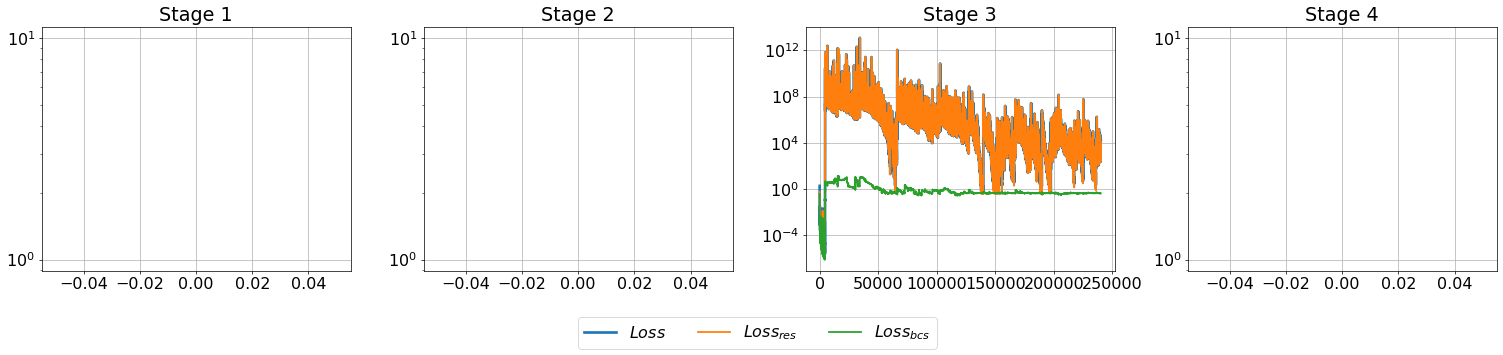

In [17]:
# loss图
loss_logger = np.load("./loss_logger_dict.npy", allow_pickle=True).item()
fig = plt.figure(figsize=(24, 5), dpi=64)
axes = fig.subplots(nrows=1, ncols=4)

for i, ax in enumerate(fig.axes):
    logger = loss_logger[f"stage{i + 1}"]
    
    ax.plot(logger["iter"], logger["loss"], label=r"$Loss$", linewidth=3)
    ax.plot(logger["iter"], logger["loss_res"], label=r"$Loss_{res}$", linewidth=2)
    ax.plot(logger["iter"], logger["loss_bcs"], label=r"$Loss_{bcs}$", linewidth=2)
    ax.set_yscale('log')
    ax.set_title(f"Stage {i + 1}")
    ax.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0), ncol=3)

plt.tight_layout()
plt.savefig('Loss.png', dpi=100, bbox_inches='tight')
plt.show()

### 验证的loss图 (包括只经backbone和经过transformer和backbone的loss)

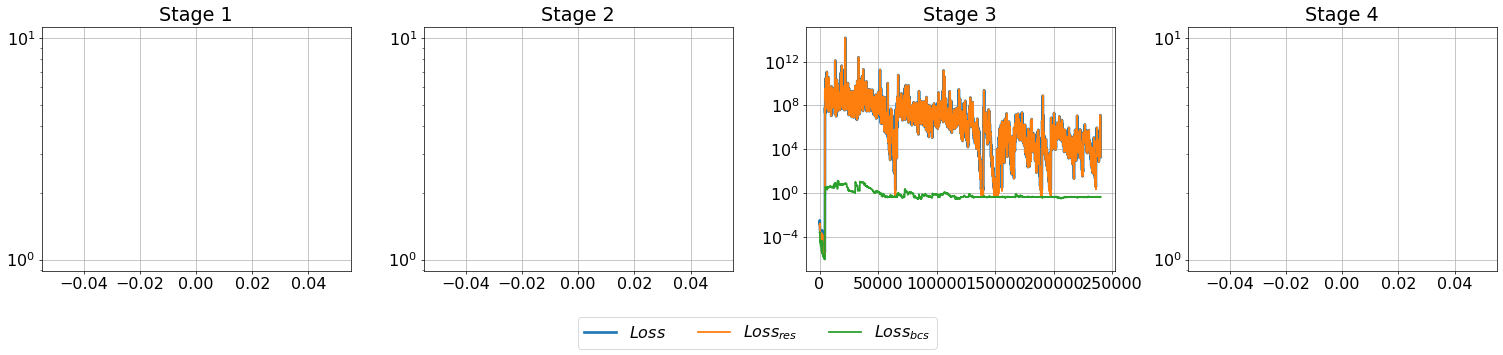

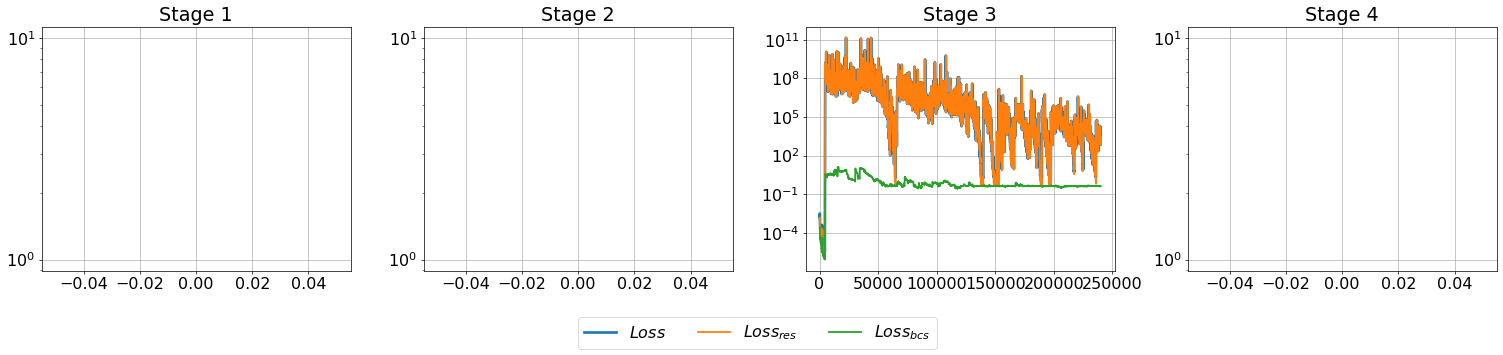

In [18]:
# valid的loss图 第一行只经过backbone 第二行经过transformer和backbone
# 因为只用backbone来valid 所以valid loss必须是对每个stage都是非增的 否则代码有误
# 由于随机采样 stage2的loss在小范围内波动属正常
# 第二行的stage2是经过transformer和backbone的 loss上升说明对抗网络是有效的
loss_logger_valid = np.load("./loss_logger_valid_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(24, 5), dpi=64)
axes = fig.subplots(nrows=1, ncols=4)

for i, ax in enumerate(fig.axes):
    logger = loss_logger_valid[f"stage{i + 1}"]
    
    ax.plot(logger["iter"], logger["loss"], label=r"$Loss$", linewidth=3)
    ax.plot(logger["iter"], logger["loss_res"], label=r"$Loss_{res}$", linewidth=2)
    ax.plot(logger["iter"], logger["loss_bcs"], label=r"$Loss_{bcs}$", linewidth=2)
    ax.set_yscale('log')
    ax.set_title(f"Stage {i + 1}")
    ax.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0), ncol=3)

plt.tight_layout()
# plt.savefig('loss_valid.png', dpi=100, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(24, 5), dpi=64)
axes = fig.subplots(nrows=1, ncols=4)

for i, ax in enumerate(fig.axes):
    logger = loss_logger_valid[f"stage{i + 1}"]
    
    ax.plot(logger["iter"], logger["loss_transformer"], label=r"$Loss$", linewidth=3)
    ax.plot(logger["iter"], logger["loss_res_transformer"], label=r"$Loss_{res}$", linewidth=2)
    ax.plot(logger["iter"], logger["loss_bcs_transformer"], label=r"$Loss_{bcs}$", linewidth=2)
    ax.set_yscale('log')
    ax.set_title(f"Stage {i + 1}")
    ax.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0), ncol=3)

plt.tight_layout()
# plt.savefig('loss_valid_transformer.png', dpi=100, bbox_inches='tight')
plt.show()

### 验证的Relative L2 error图 (包括只经backbone和经过transformer和backbone的rl2)

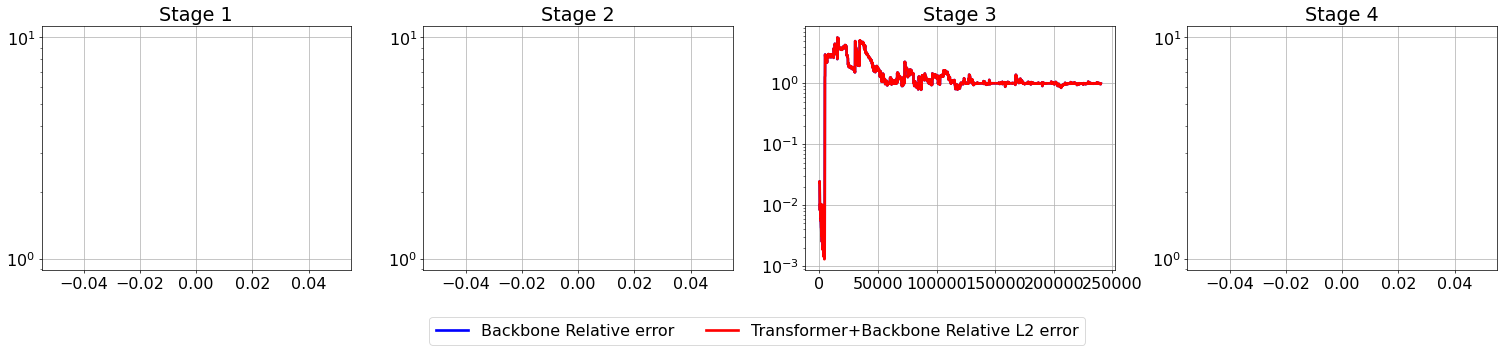

In [19]:
# valid中记录的relative l2 error记录 第一行只经过backbone 第二行经过transformer和backbone
loss_logger_valid = np.load("./loss_logger_valid_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(24, 5), dpi=64)
axes = fig.subplots(nrows=1, ncols=4)

for i, ax in enumerate(fig.axes):
    logger = loss_logger_valid[f"stage{i + 1}"]
    
    ax.plot(logger["iter"], logger["error"], label=r"Backbone Relative error", color="blue", linewidth=3)
    ax.plot(logger["iter"], logger["error_transformer"], label=r"Transformer+Backbone Relative L2 error", color="red", linewidth=3)
    
    ax.set_yscale('log')
    ax.set_title(f"Stage {i + 1}")
    ax.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0), ncol=3)

plt.tight_layout()
plt.savefig('Relative_L2_error.png', dpi=100, bbox_inches='tight')
plt.show()

### 验证的距离变化信息 d_mean d_var d_min d_max

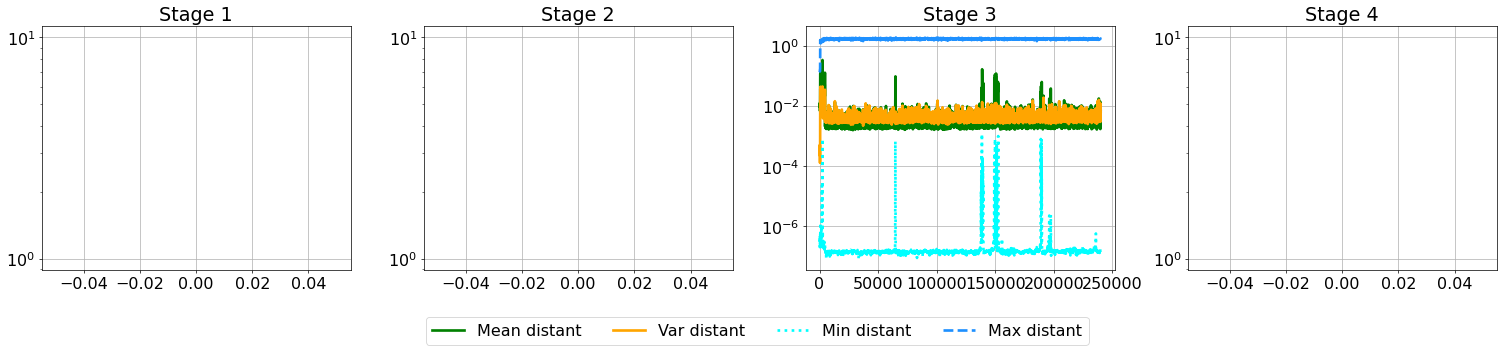

In [20]:
# valid中记录的relative l2 error记录 第一行只经过backbone 第二行经过transformer和backbone
loss_logger_valid = np.load("./loss_logger_valid_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(24, 5), dpi=64)
axes = fig.subplots(nrows=1, ncols=4)

for i, ax in enumerate(fig.axes):
    logger = loss_logger_valid[f"stage{i + 1}"]
    
    ax.plot(logger["iter"], logger["distant"]["mean"], label=r"Mean distant", color="green", linewidth=3)
    ax.plot(logger["iter"], logger["distant"]["var"], label=r"Var distant", color="orange", linewidth=3)
    ax.plot(logger["iter"], logger["distant"]["min"], label=r"Min distant", color="cyan", linestyle=':', linewidth=3)
    ax.plot(logger["iter"], logger["distant"]["max"], label=r"Max distant", color="dodgerblue", linestyle='--', linewidth=3)
    
    ax.set_yscale('log')
    ax.set_title(f"Stage {i + 1}")
    ax.grid()

lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0), ncol=4)

plt.tight_layout()
# plt.savefig('Relative_L2_error.png', dpi=100, bbox_inches='tight')
plt.show()

### Relative L2 error (仅考虑内部点）

In [21]:
# 使用最好的模型
backbone = ResNet(args.backbone_layers)
state_dict = torch.load(f'{trainer.model_path}/best_model.pth')
backbone.load_state_dict(state_dict['state_dict'])
backbone.eval()
print("Stage:\t", state_dict['stage'])
print("Iter:\t", state_dict['iter'] + 1)
print("Loss:\t", "{:.2e}".format(state_dict['best_loss']))

Stage:	 3
Iter:	 4500
Loss:	 3.62e-06


In [22]:
def exact_sol(X):
    # 解析解
    u_star = X[:, :args.dim].mean(axis=1, keepdims=True)
    u_star = np.cos(u_star) * np.exp(- X[:, [-1]])
    return u_star

# 采样内部点
dataset = Dataset_HeatHD(args.bot_top, args.T, args.dim, torch.device('cpu'))
X_res, _, _, _, _, _ = dataset.train_data(N_r=10000, N_b=0, N_0=0)
# 计算u_star u_pred
u_star = exact_sol(X_res)
u_pred = backbone(X_res)

u_star = u_star.detach().numpy()
u_pred = u_pred.detach().numpy()
#计算L2相对误差
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
with open("RL2.txt", 'w') as f:
    f.write(str(error_u))
print('Relative L2 error: {:.3e}'.format(error_u))

Relative L2 error: 1.478e-03


### 可视化内部(x1, x2, 0, ..., 0)

In [23]:
n = 101
dim = args.dim
# 取前两维
x1 = np.linspace(-1, 1, n)
x2 = np.linspace(-1, 1, n)
x1, x2 = np.meshgrid(x1, x2)
# x3, ..., x50 = 0
x12 = np.zeros((n*n, dim))
x12[:, [0]] = x1.reshape(-1, 1)
x12[:, [1]] = x2.reshape(-1, 1)
t = np.ones((x12.shape[0], 1)) * args.T
x12 = np.concatenate([x12, t], axis=1)
x12 = torch.from_numpy(x12).float()
# 解析解和预测解
u12_star = exact_sol(x12)
u12_pred = backbone(x12)

u12_star = u12_star.detach().numpy()
u12_pred = u12_pred.detach().numpy()

u12_star = u12_star.reshape(x1.shape)
u12_pred = u12_pred.reshape(x1.shape)

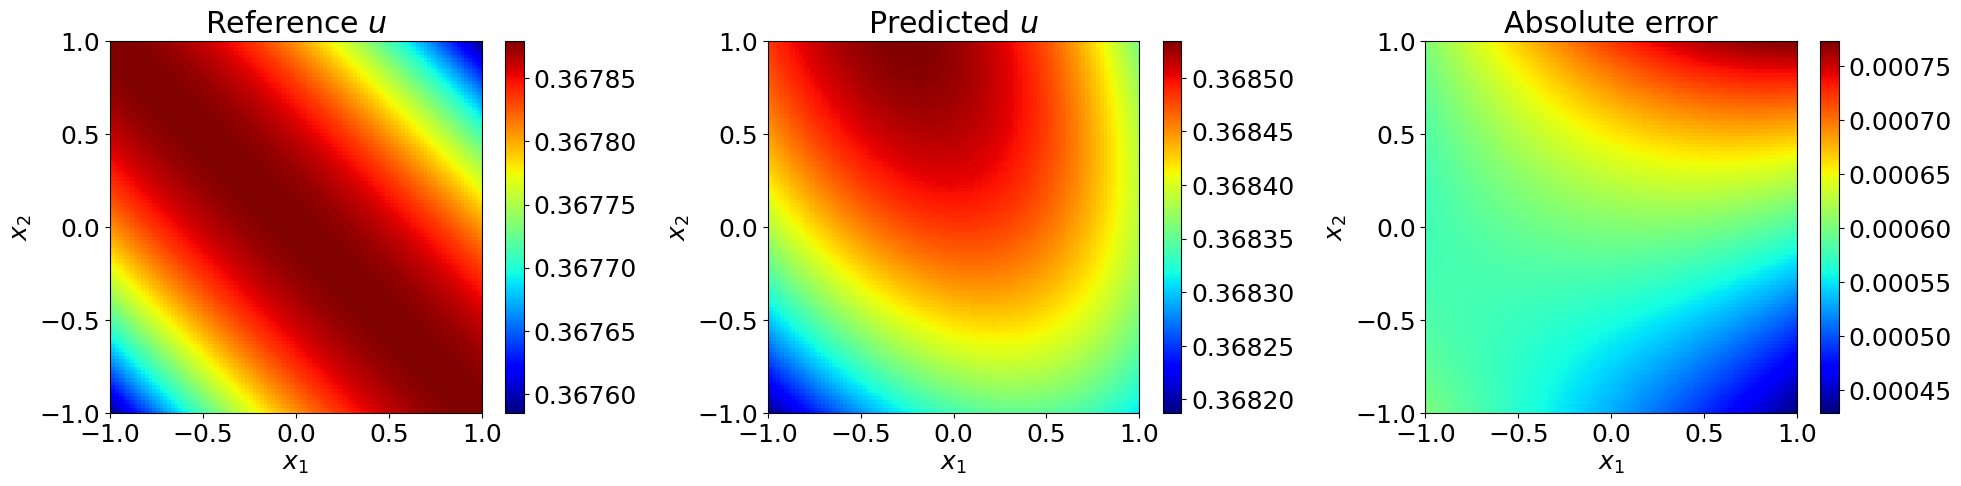

In [24]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

cax1 = axes[0].pcolor(x1, x2, u12_star, cmap='jet')
fig.colorbar(cax1)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title(r'Reference $u$')
axes[0].set_xlim([-1, 1])
axes[0].set_ylim([-1, 1])
axes[0].set_xticks(np.arange(-1, 1.1, 0.5))
axes[0].set_yticks(np.arange(-1, 1.1, 0.5))
axes[0].set_aspect(1./axes[0].get_data_ratio())

cax2 = axes[1].pcolor(x1, x2, u12_pred, cmap='jet')
fig.colorbar(cax2)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title(r'Predicted $u$')
axes[1].set_xlim([-1, 1])
axes[1].set_ylim([-1, 1])
axes[1].set_xticks(np.arange(-1, 1.1, 0.5))
axes[1].set_yticks(np.arange(-1, 1.1, 0.5))
axes[1].set_aspect(1./axes[1].get_data_ratio())

cax3 = axes[2].pcolor(x1, x2, np.abs(u12_star - u12_pred), cmap='jet')
fig.colorbar(cax3)
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_title('Absolute error')
axes[2].set_xlim([-1, 1])
axes[2].set_ylim([-1, 1])
axes[2].set_xticks(np.arange(-1, 1.1, 0.5))
axes[2].set_yticks(np.arange(-1, 1.1, 0.5))
axes[2].set_aspect(1./axes[2].get_data_ratio())

plt.tight_layout()
plt.savefig('HeatHD_result.png', dpi=100, bbox_inches='tight')
plt.show()

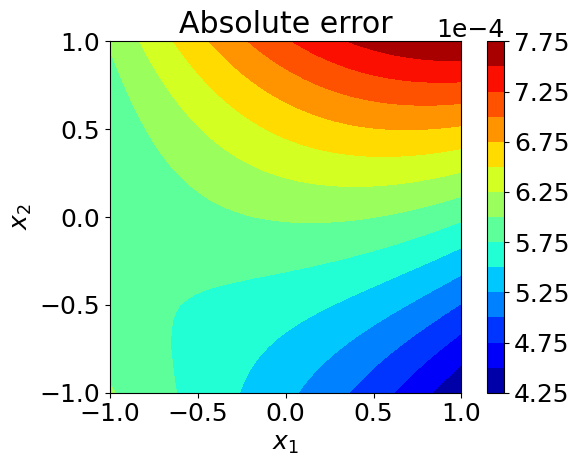

In [25]:
fig, ax = plt.subplots(figsize=(6.5, 5), dpi=100)
plot = ax.contourf(x1, x2, np.abs(u12_star - u12_pred), levels=16, cmap='jet')

cbar = fig.colorbar(plot)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_title('Absolute error')
ax.set_aspect(1./ax.get_data_ratio())

plt.tight_layout()
plt.savefig('./Absolute_error', dpi=100)
plt.show()

## Transformer变换可视化

In [26]:
# # loss_res
# trainer.device = torch.device('cpu')
# trainer.backbone = trainer.backbone.cpu()

# f_res = trainer.dataset.func_res(x12)
# f_res_pred = trainer.net_r(x12)
# loss_res = (f_res - f_res_pred) ** 2

In [27]:
# fig = plt.figure(figsize=(6.5, 5))
# ax = fig.subplots()

# cax = ax.scatter(x12.detach().numpy()[:, 0], x12.detach().numpy()[:, 1], 
#                  c=loss_res.detach().cpu().numpy(), 
# #                  vmin=0, vmax=5e-5,
#                  cmap="jet", s=80)
# fig.colorbar(cax)
# ax.set_xlabel('$x_1$')
# ax.set_ylabel('$x_2$')
# ax.set_title(r'Residual')
# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])
# ax.set_xticks(np.arange(-1, 1.1, 0.5))
# ax.set_yticks(np.arange(-1, 1.1, 0.5))
# ax.set_aspect(1./axes[0].get_data_ratio())

# plt.tight_layout()
# plt.show()

In [28]:
# # 重新取点
# n = 21
# dim = args.dim
# # 取前两维
# xx1 = np.linspace(-1, 1, n)
# xx2 = np.linspace(-1, 1, n)
# xx1, xx2 = np.meshgrid(xx1, xx2)
# # x3, ..., x50 = 0
# xx12 = np.zeros((n*n, dim))
# xx12[:, [0]] = xx1.reshape(-1, 1)
# xx12[:, [1]] = xx2.reshape(-1, 1)
# t = np.ones((xx12.shape[0], 1)) * args.T
# xx12 = np.concatenate([xx12, t], axis=1)
# xx12 = torch.from_numpy(xx12).float()

In [29]:
# # 变换后的点
# # model = MLP(args.subnet_layers)  # 保存的loss最低时的transformer
# # transformer = TransformerNet(model, args.bot_top)

# # state_dict = torch.load(f'{trainer.model_path}/best_model.pth')
# # transformer.load_state_dict(state_dict['state_dict_transformer'])
# # transformer.eval()

# # xx12_ = transformer(xx12)

# trainer.transformer = trainer.transformer.cpu()  # 训练最后的transformer
# f_xx12 = dataset.func_res(xx12)
# k = trainer.update_k(xx12, f_xx12)
# xx12_ = trainer.net_transformer(xx12, k)

In [30]:
# plt.hist(k.detach().cpu().numpy().flatten())

In [31]:
# fig = plt.figure(figsize=(12, 5))
# axes = fig.subplots(1, 2)

# axes[0].scatter(xx12.detach().numpy()[:, 0], xx12.detach().numpy()[:, 1], s=30, color='b')
# axes[0].set_xlabel('$x_1$')
# axes[0].set_ylabel('$x_2$')
# axes[0].set_title(r'Original distribution')
# axes[0].set_xlim([-1, 1])
# axes[0].set_ylim([-1, 1])
# axes[0].set_xticks(np.arange(-1, 1.1, 0.5))
# axes[0].set_yticks(np.arange(-1, 1.1, 0.5))
# axes[0].set_aspect(1./axes[0].get_data_ratio())

# axes[1].scatter(xx12_.detach().numpy()[:, 0], xx12_.detach().numpy()[:, 1], s=30, color='r')
# axes[1].set_xlabel('$x_1$')
# axes[1].set_ylabel('$x_2$')
# axes[1].set_title('Transformed distribution')
# axes[1].set_xlim([-1, 1])
# axes[1].set_ylim([-1, 1])
# axes[1].set_xticks(np.arange(-1, 1.1, 0.5))
# axes[1].set_yticks(np.arange(-1, 1.1, 0.5))
# axes[1].set_aspect(1./axes[1].get_data_ratio())

# plt.tight_layout()
# plt.show()